# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# Import Spark-related libraries for DataFrame operations and machine learning
from pyspark.sql import SparkSession, Window  # Spark session initialization and window functions
from pyspark import SparkFiles  # To access files on the cluster when running Spark
from pyspark.sql.functions import avg, col, concat, count, desc, \
asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
log, sqrt, cbrt, exp  # Various Spark SQL functions for data manipulation and calculations
from pyspark.sql.functions import split, sum as Fsum  # Aliasing sum function to avoid conflict with built-in sum()
from pyspark.sql.types import IntegerType, StringType  # Data type for integer columns in Spark DataFrames
from pyspark.sql import functions as F # Define F for feature enginerring

# Import ML-related libraries for building machine learning models
from pyspark.ml import Pipeline  # For creating machine learning pipelines
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel  # Classification algorithms (logistic regression, random forest, gradient boosted trees)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator  # For evaluating multiclass classification models
from pyspark.mllib.evaluation import MulticlassMetrics  # For evaluating classification models using Spark's old MLlib

# Import feature engineering and preprocessing methods
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler  # Tools for text vectorization, scaling, and feature transformation
from pyspark.ml.regression import LinearRegression  # Regression models
from pyspark.ml.clustering import KMeans  # Clustering algorithm for unsupervised learning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder  # For hyperparameter tuning and cross-validation

# Import time-related libraries
import os
import random
from time import time  # For measuring execution time

# Import other data science libraries
import re  # For regular expressions (useful in text processing)
import numpy as np  # For numerical operations (numpy arrays, linear algebra, etc.)
import scipy  # For scientific computing, such as optimization, interpolation, etc.
import pandas as pd  # For working with structured data in DataFrames
import datetime  # For working with date and time objects
import matplotlib.pyplot as plt  # For plotting data (graphs, charts)
from pandas.plotting import scatter_matrix  # For creating scatter plot matrices (visualizing relationships between features)
import seaborn as sns  # For statistical data visualization and plots
import random  # For generating random numbers and selecting random values

# Jupyter/Colab magic command for inline plotting
%matplotlib inline

# Set a seed for random number generation to ensure reproducibility
random.seed(1999)

# Optional: Verify Spark version (useful in Colab to ensure the environment is ready)
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.3
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.25
Branch HEAD
Compiled by user haejoon.lee on 2024-09-09T05:20:05Z
Revision 32232e9ed33bb16b93ad58cfde8b82e0f07c0970
Url https://github.com/apache/spark
Type --help for more information.


In [2]:
# create a Spark session
# Set the master URL to "local" and Name the Spark application
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

## Load Data

In [3]:
# Dynamically set the number of shuffle partitions based on available cores
num_cores = spark.sparkContext.defaultParallelism  # Number of cores in the cluster
spark.conf.set("spark.sql.shuffle.partitions", num_cores * 2)

In [4]:
# Download data to Colab
!wget https://www.dropbox.com/scl/fi/6yg3tq4dwkc6fu85l9u3d/mini_sparkify_event_data.json?rlkey=2gd9b22ha8zhqhk9qao7lvkbr&st=pzdmqbat&dl=0
os.rename("mini_sparkify_event_data.json?rlkey=2gd9b22ha8zhqhk9qao7lvkbr", "mini_sparkify_event_data.json")

# Open-source table that connects geographical divisions to state names
!wget https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv

--2024-11-23 07:58:18--  https://www.dropbox.com/scl/fi/6yg3tq4dwkc6fu85l9u3d/mini_sparkify_event_data.json?rlkey=2gd9b22ha8zhqhk9qao7lvkbr
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc31a8eef257da43c8c7bc4be367.dl.dropboxusercontent.com/cd/0/inline/Ce6a92UdBhDiIlcCHRR_fmsOgMnnKapFpih_JWXIJZQAOcF0lbDvNaDqNh9X54E2SGPbwup0hwZMjafNjX6FbI3jKqvV0WKfGHJYvJyN8jgwrl_XhAjqMbSn6YNKXzC9ZGAaqej26YvGDX0d5wE4K_C8/file# [following]
--2024-11-23 07:58:19--  https://uc31a8eef257da43c8c7bc4be367.dl.dropboxusercontent.com/cd/0/inline/Ce6a92UdBhDiIlcCHRR_fmsOgMnnKapFpih_JWXIJZQAOcF0lbDvNaDqNh9X54E2SGPbwup0hwZMjafNjX6FbI3jKqvV0WKfGHJYvJyN8jgwrl_XhAjqMbSn6YNKXzC9ZGAaqej26YvGDX0d5wE4K_C8/file
Resolving uc31a8eef257da43c8c7bc4be367.dl.dropboxusercontent.com (uc31a8eef257da43c8c7bc4be367.dl.dropboxusercontent.com)... 162

In [5]:
# Read a CSV file
region = pd.read_csv("us census bureau regions and divisions.csv")
region.to_csv("us census bureau regions and divisions.csv", index=False)
region.head()

# Create or get the Spark session
spark = SparkSession.builder.appName('PandasToSpark').getOrCreate()

# Convert Pandas DataFrame to Spark DataFrame
locations_with_region = spark.createDataFrame(region)

# Show the first few rows of the Spark DataFrame
locations_with_region.show()

+--------------------+----------+---------+------------------+
|               State|State Code|   Region|          Division|
+--------------------+----------+---------+------------------+
|              Alaska|        AK|     West|           Pacific|
|             Alabama|        AL|    South|East South Central|
|            Arkansas|        AR|    South|West South Central|
|             Arizona|        AZ|     West|          Mountain|
|          California|        CA|     West|           Pacific|
|            Colorado|        CO|     West|          Mountain|
|         Connecticut|        CT|Northeast|       New England|
|District of Columbia|        DC|    South|    South Atlantic|
|            Delaware|        DE|    South|    South Atlantic|
|             Florida|        FL|    South|    South Atlantic|
|             Georgia|        GA|    South|    South Atlantic|
|              Hawaii|        HI|     West|           Pacific|
|                Iowa|        IA|  Midwest|West North C

In [6]:
# Read a JSON file into a Spark DataFrame
df = spark.read.json('mini_sparkify_event_data.json')
# This reads the JSON file 'mini_sparkify_event_data.json' and loads it into a DataFrame (df).
# Spark automatically infers the schema of the JSON data, so each field in the JSON file becomes a column in the DataFrame.

In [7]:
# Print the schema of the DataFrame
df.printSchema()
# This prints the schema of the DataFrame (df), which includes the column names and their inferred data types.
# It helps you understand the structure of the loaded data, such as the data types of each column.

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# Show the first 5 rows of the DataFrame
df.show(5)
# This displays the first 5 rows of the DataFrame in a tabular format.
# You can change the number to display more or fewer rows.

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [9]:
# Get the number of rows and columns in the DataFrame
num_rows, num_cols = df.count(), len(df.columns)
print(f"Number of rows: {num_rows}, Number of columns: {num_cols}")

Number of rows: 286500, Number of columns: 18


In [10]:
# Show distinct values of a column, for example, 'userId'
df.select('userId').distinct().show()
# This will display the unique values in the 'userId' column.

+------+
|userId|
+------+
|    74|
|      |
|     4|
|    45|
|    87|
|   131|
|   126|
|   146|
|    36|
|   120|
|    27|
|   140|
|    81|
|   137|
|    65|
|    29|
|    70|
|    61|
|   136|
|    80|
+------+
only showing top 20 rows



In [11]:
# Show summary statistics for numerical columns
df.describe().show()
# This will show statistics such as count, mean, standard deviation, min, and max for numeric columns.

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [12]:
# Print the data types of all columns
for column, dtype in df.dtypes:
    print(f"Column: {column}, Type: {dtype}")
# This iterates over the DataFrame columns and prints the name and data type of each column.

Column: artist, Type: string
Column: auth, Type: string
Column: firstName, Type: string
Column: gender, Type: string
Column: itemInSession, Type: bigint
Column: lastName, Type: string
Column: length, Type: double
Column: level, Type: string
Column: location, Type: string
Column: method, Type: string
Column: page, Type: string
Column: registration, Type: bigint
Column: sessionId, Type: bigint
Column: song, Type: string
Column: status, Type: bigint
Column: ts, Type: bigint
Column: userAgent, Type: string
Column: userId, Type: string


## Clean Data

### Check for missing *values*

In [13]:
# Print the total number of rows in the dataset
total_rows = df.count()
print(f"Total number of rows in the dataset: {total_rows}.\n")

# Initialize a counter for total missing values across all columns
missing_count_total = 0

# Collect missing counts for all columns in one go
missing_summary = {}

# Loop through each column to get NaN, Null, and empty counts
for coln in df.columns:
    # Aggregate missing values (NaN, Null, Empty Strings) in a single pass
    summary = df.agg(
        (count(when(isnan(df[coln]), 1))).alias('nan_count'),
        (count(when(df[coln].isNull(), 1))).alias('null_count'),
        (count(when(df[coln] == "", 1))).alias('empty_str')
    ).first()

    # Calculate total missing values for the column
    nan_count = summary['nan_count']
    null_count = summary['null_count']
    empty_str = summary['empty_str']
    missing_count = nan_count + null_count + empty_str

    # Store missing summary for each column
    missing_summary[coln] = {
        'nan_count': nan_count,
        'null_count': null_count,
        'empty_str': empty_str,
        'missing_count': missing_count
    }

    # If the column has missing values, print the breakdown
    if missing_count > 0:
        print(f"{coln}: {missing_count} missing values. "
              f"{nan_count} NaN's; {null_count} Null's; {empty_str} empty strings.")

        # Add to the total missing count
        missing_count_total += missing_count

# If no missing values were found in any column, print a confirmation message
if missing_count_total == 0:
    print("No missing values.")

Total number of rows in the dataset: 286500.

artist: 58392 missing values. 0 NaN's; 58392 Null's; 0 empty strings.
firstName: 8346 missing values. 0 NaN's; 8346 Null's; 0 empty strings.
gender: 8346 missing values. 0 NaN's; 8346 Null's; 0 empty strings.
lastName: 8346 missing values. 0 NaN's; 8346 Null's; 0 empty strings.
length: 58392 missing values. 0 NaN's; 58392 Null's; 0 empty strings.
location: 8346 missing values. 0 NaN's; 8346 Null's; 0 empty strings.
registration: 8346 missing values. 0 NaN's; 8346 Null's; 0 empty strings.
song: 58392 missing values. 0 NaN's; 58392 Null's; 0 empty strings.
userAgent: 8346 missing values. 0 NaN's; 8346 Null's; 0 empty strings.
userId: 8346 missing values. 0 NaN's; 0 Null's; 8346 empty strings.


#### Missing values in userId and sessionId

In [14]:
# Get the number of rows in the original DataFrame (only once)
num_rows = df.count()
print(f"There are {num_rows} rows in the dataset.")

# Drop rows where 'userId' or 'sessionId' is null
df_cleaned = df.dropna(how='any', subset=['userId', 'sessionId'])

# Get the number of rows after dropping the NaN values
num_dropped = num_rows - df_cleaned.count()

# Print the result for dropped rows
print(f"{num_dropped} rows were dropped because they contained missing values in either 'userId' or 'sessionId'.")

There are 286500 rows in the dataset.
0 rows were dropped because they contained missing values in either 'userId' or 'sessionId'.


In [15]:
# Select the 'userId' column, remove duplicate entries,
# and then order the results in ascending order by 'userId'
df.select(['userId']).dropDuplicates().orderBy(df['userId']).show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



> I was able to input an userId of empty string and this looks very suspicious. What is happening I will try to find out by choosing the page events where userId is empty in contrast to all userId

In [16]:
# Create or replace a temporary view called "df_table"
df.createOrReplaceTempView("df_table")

In [17]:
# Run SQL query to select distinct 'page' values where userId is an empty string
spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    WHERE userId = ""
    '''
).show()

+-------------------+
|               page|
+-------------------+
|               Home|
|               Help|
|              Login|
|              About|
|              Error|
|           Register|
|Submit Registration|
+-------------------+



In [18]:
# The following SQL query retrieves distinct 'page' values from the 'df_table'
# and excludes the 'page' values where 'userId' is an empty string.
# This is achieved using the EXCEPT operator to remove rows from the first query
# that are present in the second query, where 'userId' is an empty string.

spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    EXCEPT
    SELECT DISTINCT page
    FROM df_table
    WHERE userId = ""
    '''
).show()

+--------------------+
|                page|
+--------------------+
|            NextSong|
|      Submit Upgrade|
|       Save Settings|
|              Cancel|
|           Thumbs Up|
|              Logout|
|            Settings|
|    Submit Downgrade|
|     Add to Playlist|
|             Upgrade|
|          Add Friend|
|         Roll Advert|
|           Downgrade|
|         Thumbs Down|
|Cancellation Conf...|
+--------------------+



>An userId of empty string most probably refers to one or some users who might be in the state of login or even sing-up. Hence, rows with empty userId are excluded

In [19]:
# The following line filters the DataFrame to exclude rows where 'userId' is an empty string.
# After applying this filter, only the rows with a non-empty 'userId' will remain in the DataFrame.

df = df.filter(df['userId'] != "")

> For this session because of sessionId column numeric in nature we shall not worry so much about empty strings affecting this column

In [20]:
# This code prints the number of missing values (NaN, Null, or empty string) for selected columns in the DataFrame.

# Print the header for missing values report
print("Number of missing values:")

# Loop through a list of columns to check for missing values
for coln in ['userId', 'sessionId', 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent']:
    # Count the missing values by checking for NaN, Null, or empty strings
    missing_count = df.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()

    # Print the count of missing values for each column
    print(f"    {coln}: {missing_count} missing values.")

Number of missing values:
    userId: 0 missing values.
    sessionId: 0 missing values.
    firstName: 0 missing values.
    gender: 0 missing values.
    lastName: 0 missing values.
    location: 0 missing values.
    registration: 0 missing values.
    userAgent: 0 missing values.


#### Missing values in artist, length, song

In [21]:
# The following code filters the DataFrame to find rows where the 'artist' column is Null.
# It then selects the 'page' column from those rows, drops duplicate values, and displays the result.
df.filter(df['artist'].isNull()).select(df['page']).dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|           Thumbs Up|
|                Home|
|              Logout|
|                Help|
|            Settings|
|      Submit Upgrade|
|               About|
|    Submit Downgrade|
|               Error|
|       Save Settings|
|              Cancel|
|     Add to Playlist|
|         Roll Advert|
|           Downgrade|
|         Thumbs Down|
|             Upgrade|
|          Add Friend|
|Cancellation Conf...|
+--------------------+



In [22]:
# Filter the DataFrame to find rows where the 'artist' column is not Null.
# Then, select the 'page' column from those rows, remove any duplicate values,
# and display the resulting unique 'page' values.
df.filter(df['artist'].isNotNull()).select(df['page']).dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



> From the analyzing of csv columns, we found that only page event “NextSong”, or playing a song, has corresponding artist information, which is quite reasonable. This should be for the artist, length, and song columm

In [23]:
# Filter the DataFrame to select rows where the 'page' event is 'NextSong'.
df_song = df.filter(df['page'] == "NextSong")

# Print the message indicating that we are checking the missing values for 'NextSong' events.
print("When page event is 'NextSong':")

# Loop through the selected columns ('artist', 'length', 'song') to check for missing values.
for coln in ['artist', 'length', 'song']:
    # For each column, count the missing values (NaN, Null, or empty string) and print the result.
    missing_count = df_song.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    print(f"    {coln}: {missing_count} missing values.")

When page event is 'NextSong':
    artist: 0 missing values.
    length: 0 missing values.
    song: 0 missing values.


### Handling Duplicates
> I will leave out the repeated cleaning since in the dataset there are many similar entries of userId and sessionId due to the events per user-session mapping. Eliminating these duplicates cuts down the dataset considerably, and paradoxically, it is the event level detail that is often critical for analysis

#### Identify Duplicates

In [24]:
# # Count the number of rows before removing duplicates
# initial_count = df.count()
# print(f"Initial number of rows: {initial_count}")

# # Show some sample duplicate rows (if necessary)
# df_duplicate = df.groupBy(df.columns).count().filter("count > 1")
# df_duplicate.show()

In [25]:
# # Group the DataFrame by 'userId' and 'sessionId' columns to find duplicate entries
# # that have the same 'userId' and 'sessionId' but occur more than once.
# df_duplicate = df.groupBy("userId", "sessionId").count().filter("count > 1")  # Filter to only keep rows where the count is greater than 1 (indicating duplicates)

# # Show the resulting DataFrame with duplicate 'userId' and 'sessionId' combinations.
# df_duplicate.show()

#### Remove Duplicates Based on userId and sessionId

In [26]:
# # Count the number of rows before removing duplicates
# initial_count = df.count()
# print(f"Initial number of rows: {initial_count}")

# # Remove duplicates based on userId and sessionId
# df_cleaned = df.dropDuplicates(["userId", "sessionId"])

# # Count the number of rows after removing duplicates
# final_count = df_cleaned.count()
# print(f"Number of rows after removing duplicates: {final_count}")

# # Calculate and print the difference in row count
# removed_count = initial_count - final_count
# print(f"Number of rows removed: {removed_count}")

# Exploratory Data Analysis

## Conduct EDA using only a part of the entire data set.

In [27]:
# Define the sample size of users to select
user_sample_size = 250

# Retrieve the unique userIds from the DataFrame
users = [row.userId for row in df.select('userId').dropDuplicates().collect()]

# Check if the number of unique users is greater than the sample size
if len(users) > user_sample_size:
    # If more unique users than the sample size, randomly select users without replacement
    user_sample = list(np.random.choice(users, size=user_sample_size, replace=False))
else:
    # If there are fewer or equal unique users than the sample size, use all users
    user_sample = list(np.copy(users))

# Filter the DataFrame to include only rows with the selected userIds
df_sub = df.filter(df['userId'].isin(user_sample))

## Overview of numerical columns

In [28]:
# Define a list of column names that are relevant for analysis or transformation
num_cols = ['itemInSession', 'registration', 'status', 'ts', 'length']

# Select the specified columns from the DataFrame and calculate descriptive statistics
df_sub.select(num_cols).describe().show()  # Display the results

+-------+------------------+--------------------+------------------+--------------------+-----------------+
|summary|     itemInSession|        registration|            status|                  ts|           length|
+-------+------------------+--------------------+------------------+--------------------+-----------------+
|  count|            278154|              278154|            278154|              278154|           228108|
|   mean|114.89918174824018|1.535358834084427...|209.10321620397335|1.540958915431871...|249.1171819778458|
| stddev|  129.851729399489| 3.291321616327586E9|30.151388851328214|1.5068287123306298E9|99.23517921058361|
|    min|                 0|       1521380675000|               200|       1538352117000|          0.78322|
|    max|              1321|       1543247354000|               404|       1543799476000|       3024.66567|
+-------+------------------+--------------------+------------------+--------------------+-----------------+



In [29]:
# Specify the column name to check for unique values
coln = 'status'

# Print a message indicating the column for which unique values will be displayed
print(f"Possible values of '{coln}':")

# Select the unique values from the 'status' column, drop duplicates, and collect the results into a list
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'status':
[200, 307, 404]


> Status values do not have continuous meanings hence I shall treat column status as a categorial variable

## Overview of non-numerical columns

In [30]:
# Define a list of categorical columns to analyze
cat_cols = ['artist', 'auth', 'firstName', 'lastName', 'gender', 'level', 'location',
            'method', 'page', 'song', 'userAgent']

# Specify the column name to check for unique values
coln = 'auth'

# Print a message indicating the column for which unique values will be displayed
print(f"Possible values of '{coln}':")

# Select the unique values from the 'auth' column, drop duplicates, and collect the results into a list
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'auth':
['Logged In', 'Cancelled']


In [31]:
# Check and print the unique values for the 'gender' column
coln = 'gender'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'gender':
['M', 'F']


In [32]:
# Check and print the unique values for the 'level' column
coln = 'level'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'level':
['paid', 'free']


In [33]:
# Check and print the unique values for the 'method' column
coln = 'method'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'method':
['PUT', 'GET']


In [34]:
# Check and print the unique values for the 'page' column
coln = 'page'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'page':
['NextSong', 'Thumbs Up', 'Home', 'Logout', 'Help', 'Settings', 'Submit Upgrade', 'About', 'Submit Downgrade', 'Error', 'Save Settings', 'Cancel', 'Add to Playlist', 'Roll Advert', 'Downgrade', 'Thumbs Down', 'Upgrade', 'Add Friend', 'Cancellation Confirmation']


In [35]:
# Check and print the unique values for the 'userAgent' column
coln = 'userAgent'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()[:10]])  # Limiting to the first 10 unique values

Possible values of 'userAgent':
['Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0', 'Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', '"Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.74.9 (KHTML, like Gecko) Version/7.0.2 Safari/537.74.9"', '"Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, l

In [36]:
# Filter the rows where the 'status' is 404 and select unique combinations of 'status' and 'page'
df_sub.select(['status', 'page']).where(df_sub['status'] == 404).dropDuplicates().show()

+------+-----+
|status| page|
+------+-----+
|   404|Error|
+------+-----+



## Define churn
> Produce a column that will be labeled as Churn for the model. I wanted to use Cancellation Confirmation events to define churn, which occur for consumers of both paid and non-paid subscriptions. To measure churn in this research, no usage of any music service is considered, irrespective of whether they are a free or a paid user

In [37]:
# Define a User Defined Function (UDF) to flag 'Cancellation Confirmation' events as churn (1) and others as non-churn (0)
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

# Apply the UDF to create a new column "churned", where 1 indicates the event is a churn event and 0 otherwise
df_sub = df_sub.withColumn("churned", flag_churn_event("page"))

# Calculate the percentage of users who have churned
# Group by 'userId', sum the churned values (i.e., count the churn events per user), then calculate the average of churned users
pctg = df_sub.groupBy('userId').agg({'churned': 'sum'})\
    .select(avg('sum(churned)')).collect()[0]['avg(sum(churned))']

# Print the percentage of users who have churned, rounded to one decimal place
print(f"{round(pctg*100, 1)}% users have churned.")

23.1% users have churned.


In [38]:
# Define a window specification to partition the data by 'userId' and order by timestamp ('ts')
# This will allow us to calculate cumulative churn for each user over time.
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# Create a new column 'churnPhase' which tracks the cumulative churn count for each user at each timestamp
# If 'churned' is 1, it will increment the cumulative churn count
df_sub = df_sub.withColumn("churnPhase", Fsum('churned').over(windowval))

# Create a new column 'churnUser' which marks a user as a churned user if they have any churn event (churned == 1)
# The 'max' function is used to identify if the user has churned at any point in time.
df_sub = df_sub.withColumn("churnUser", max('churned').over(Window.partitionBy("userId")))

## Explore data
> The last relevant type of behavior-aware analysis is to compare the behavior of users who remained active in the service, with the behavior of those who decided to leave

In [39]:
# Define a UDF to extract the hour from the timestamp ('ts')
# The timestamp is in milliseconds, so we divide by 1000 to convert to seconds, and then use datetime to get the hour.
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
df_sub = df_sub.withColumn("hour", get_hour(df_sub.ts))  # Add the 'hour' column to the DataFrame

In [40]:
# Define a UDF to extract the day of the month from the timestamp ('ts')
# The timestamp is converted from milliseconds to seconds before extracting the day.
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
df_sub = df_sub.withColumn("day", get_day(df_sub.ts))  # Add the 'day' column to the DataFrame

In [41]:
# Define a UDF to extract the weekday (0 = Monday, 6 = Sunday) from the timestamp ('ts')
# Convert the timestamp to a datetime object and get the weekday value.
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
df_sub = df_sub.withColumn("weekday", get_weekday(df_sub.ts))  # Add the 'weekday' column to the DataFrame

In [42]:
# Define a UDF to flag the "Submit Downgrade" page event as 1, and others as 0
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_sub = df_sub.withColumn("pageDowngrade", flag_downgrade_event("page"))  # Add the 'pageDowngrade' column to the DataFrame

In [43]:
# Calculate the cumulative sum of 'pageDowngrade' for each user (from the start to the current row)
# This flags whether a user has downgraded (1 means the user has downgraded at some point).
df_sub = df_sub.withColumn("pageDowngradePhase", Fsum('pageDowngrade').over(windowval))

In [44]:
# Create a temporary view from the DataFrame so that we can run SQL queries on it
df_sub.createOrReplaceTempView("df_sub_table")

### Churn and hour plot

Text(0.5, 1.0, 'Churn rate and hour of a day')

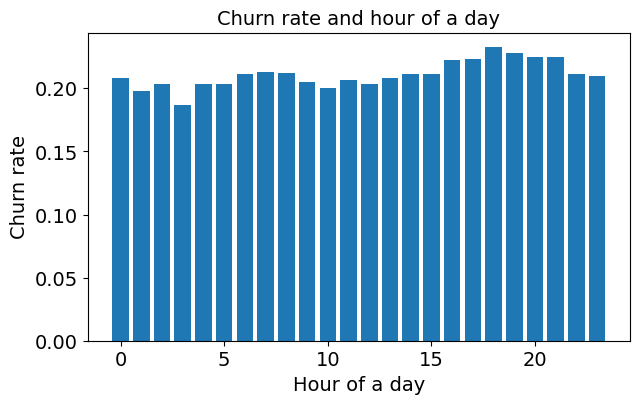

In [45]:
# Select the relevant columns and remove duplicates
# Then, group by 'hour' and calculate the number of users and number of churned users for each hour
hourly = df_sub.select(['userId', 'hour', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('hour')\
    .agg(count('userId').alias('num_users'),  # Count the number of unique users for each hour
         Fsum('churnUser').alias('num_churns'))  # Sum the churned users for each hour

# Convert the resulting DataFrame to a Pandas DataFrame for easier plotting
hourly_df = hourly.toPandas()

# Visualize the churn rate and hour of the day using a bar chart
plt.figure(figsize=(7,4))  # Set the size of the plot
plt.bar(hourly_df['hour'], hourly_df['num_churns'] / hourly_df['num_users'])  # Plot churn rate (num_churns / num_users)
plt.xticks(fontsize=14)  # Set font size for x-axis ticks
plt.yticks(fontsize=14)  # Set font size for y-axis ticks
plt.xlabel("Hour of a day", fontsize=14)  # Label for the x-axis
plt.ylabel("Churn rate", fontsize=14)  # Label for the y-axis
plt.title("Churn rate and hour of a day", fontsize=14)  # Title for the plot

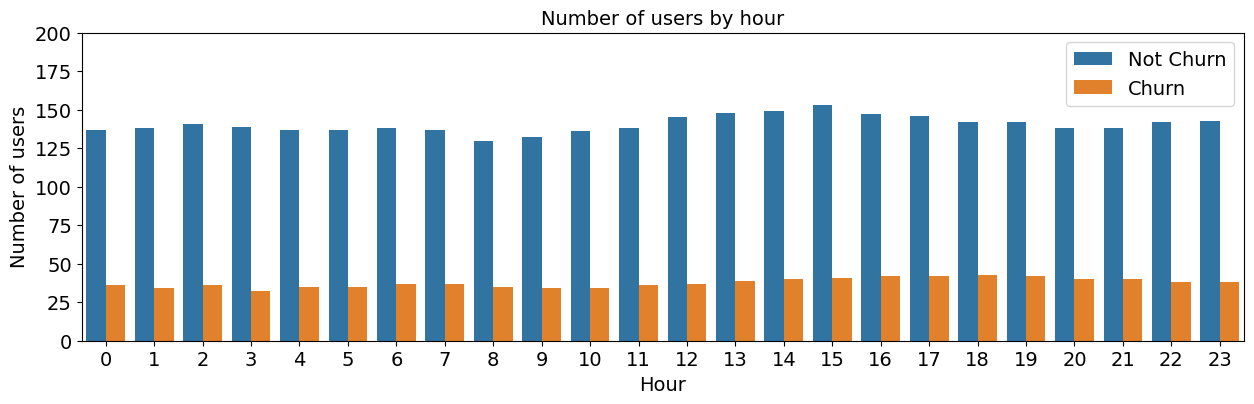

In [46]:
# Create a UDF (User Defined Function) to label churned and non-churned users
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

# Prepare the dataset by selecting the relevant columns, dropping duplicates,
# and labeling the churned users
hour_users_pd = df_sub.select(['userId', 'hour', 'churnUser'])\
    .dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()  # Convert the Spark DataFrame to a Pandas DataFrame for easier plotting

# Create a figure for plotting the count of churned and non-churned users by hour
fig = plt.figure(figsize=(15, 4))  # Set the size of the figure

# Create a countplot to visualize the number of churned and non-churned users by hour
sns.countplot(x="hour", hue="churnUser", data=hour_users_pd,
              hue_order=['Not Churn', 'Churn'])  # Plot with different colors for churned vs non-churned

# Customize plot appearance
plt.xticks(fontsize=14)  # Set font size for x-axis ticks
plt.yticks(fontsize=14)  # Set font size for y-axis ticks
plt.ylim(0, 200)  # Limit the y-axis values (number of users) to improve readability
plt.xlabel("Hour", fontsize=14)  # Label for the x-axis
plt.ylabel("Number of users", fontsize=14)  # Label for the y-axis
plt.title("Number of users by hour", fontsize=14)  # Title for the plot
plt.legend(loc='best', fontsize=14)  # Set the legend position and font size

<Figure size 1500x400 with 0 Axes>

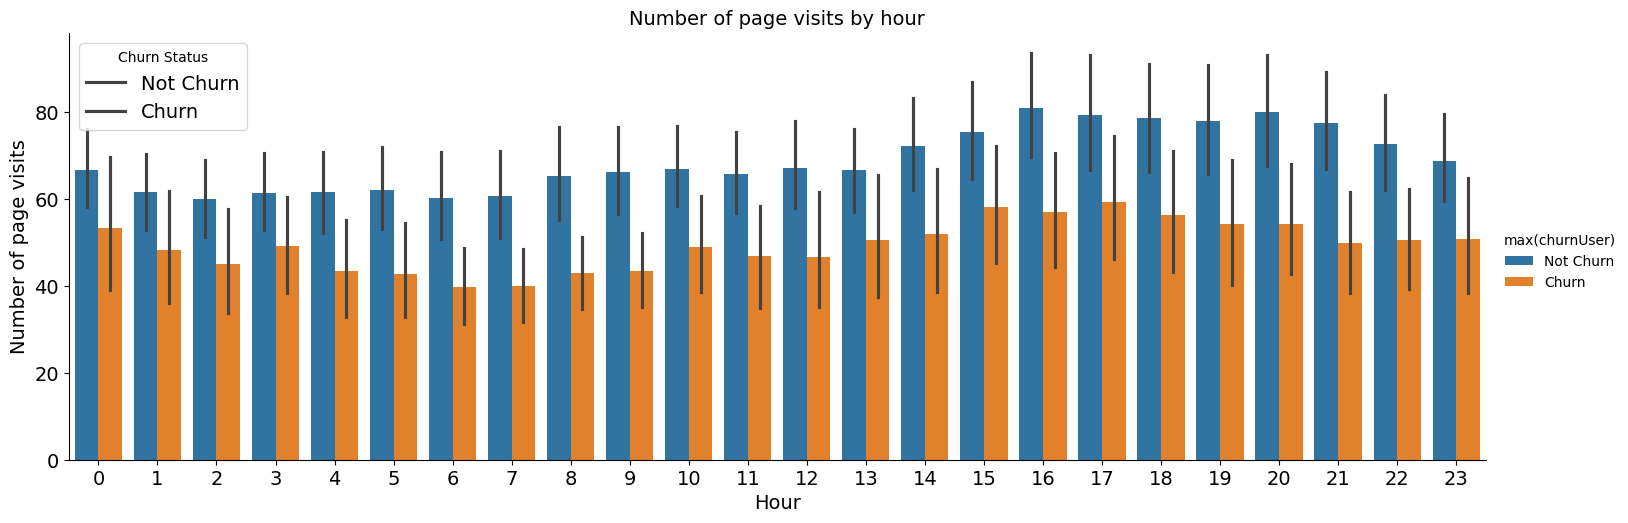

In [47]:
# Group the data by userId and hour, and aggregate by the number of page events and max churn status
hour_usage_pd = df_sub.groupBy(['userId', 'hour'])\
    .agg(count('page'), max('churnUser'))\
    .withColumn('max(churnUser)', func_churn_label('max(churnUser)'))\
    .toPandas()  # Convert the Spark DataFrame to a Pandas DataFrame for plotting

# Create a figure for plotting the number of page visits by hour
fig = plt.figure(figsize=(15, 4))  # Set the size of the figure

# Create a bar plot to visualize the number of page visits by hour, split by churn status
g = sns.catplot(x="hour", y="count(page)", hue="max(churnUser)", data=hour_usage_pd,
                kind="bar", aspect=3, legend=True)  # Plot number of page visits by hour

# Customize plot appearance
plt.xticks(fontsize=14)  # Set font size for x-axis ticks
plt.yticks(fontsize=14)  # Set font size for y-axis ticks
plt.xlabel("Hour", fontsize=14)  # Label for the x-axis
plt.ylabel("Number of page visits", fontsize=14)  # Label for the y-axis
plt.title("Number of page visits by hour", fontsize=14)  # Title for the plot

# Manually adjust the legend
g.ax.legend(title="Churn Status", labels=["Not Churn", "Churn"], fontsize=14)  # Customize legend title and labels

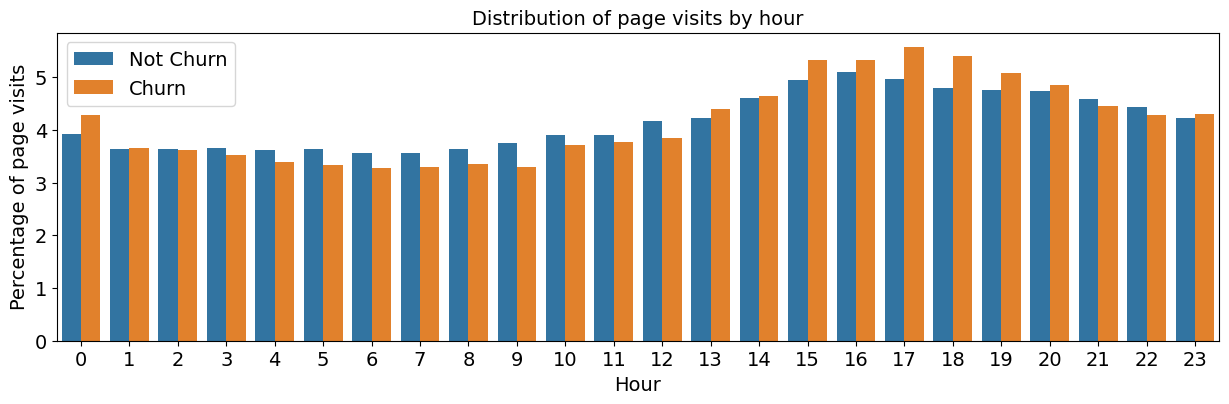

In [48]:
# Create a UDF (User Defined Function) to label 'churned' users
# If 'churned' status is 1, label as 'Churn'; otherwise label as 'Not Churn'
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

# Apply the UDF to the 'churnUser' column to create a new column with labeled churn status
# Convert the DataFrame to a Pandas DataFrame for further analysis
hour_usage_pd = df_sub.withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

# Group by 'churnUser' and 'hour', calculate the percentage of users in each hour for both churned and non-churned users
# Use 'value_counts' to calculate the frequency, normalize it to get percentage, multiply by 100, and reset the index
hour_usage_pd = hour_usage_pd.groupby(['churnUser'])['hour']\
    .value_counts(normalize=True).rename('percentage').mul(100).reset_index()

# Create a figure for plotting the data with a size of 15x4 inches
fig = plt.figure(figsize=(15, 4))

# Create a bar plot with Seaborn: 'hour' on x-axis, 'percentage' on y-axis, split by 'churnUser'
# Specify 'hue_order' to control the order of the 'churnUser' categories in the legend
sns.barplot(x="hour", y="percentage", hue="churnUser", data=hour_usage_pd,
              hue_order=['Not Churn', 'Churn'])

# Set font size for x-axis and y-axis labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label the x-axis and y-axis
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Percentage of page visits", fontsize=14)

# Set the title for the plot
plt.title("Distribution of page visits by hour", fontsize=14)

# Adjust the legend and font size
plt.legend(loc='best', fontsize=14)

### Churn and weekday

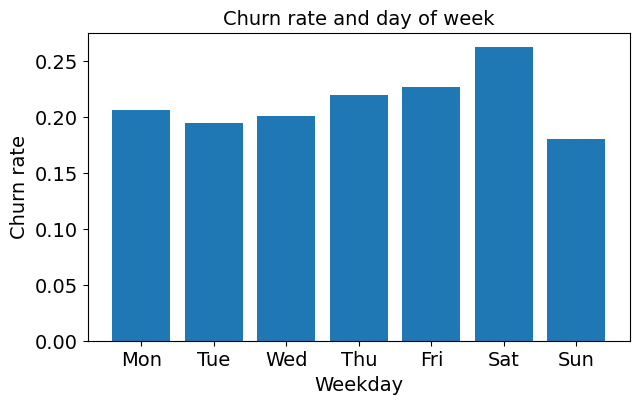

In [49]:
# Group the data by 'weekday' and 'userId', calculate the number of unique users ('num_users') and the sum of churned users ('num_churns') for each weekday
daily = df_sub.select(['userId', 'weekday', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('weekday')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))

# Convert the resulting DataFrame to a Pandas DataFrame for easier plotting
daily_df = daily.toPandas()

# Create a bar plot to visualize churn rate by weekday
# The x-axis represents the weekday, and the y-axis represents the churn rate (num_churns / num_users)
plt.figure(figsize=(7,4))
plt.bar(daily_df['weekday'], daily_df['num_churns'] / daily_df['num_users'])

# Set font size for the x and y ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label the axes with appropriate text and font size
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)

# Customize the x-axis labels to show days of the week (Mon, Tue, etc.)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Set the title for the plot
plt.title("Churn rate and day of week", fontsize=14);

> We can see that the greatest number of subscribers cancel their subscriptions on saturday. This appears to point that there is high tendency for the Friday users of the application to chorn

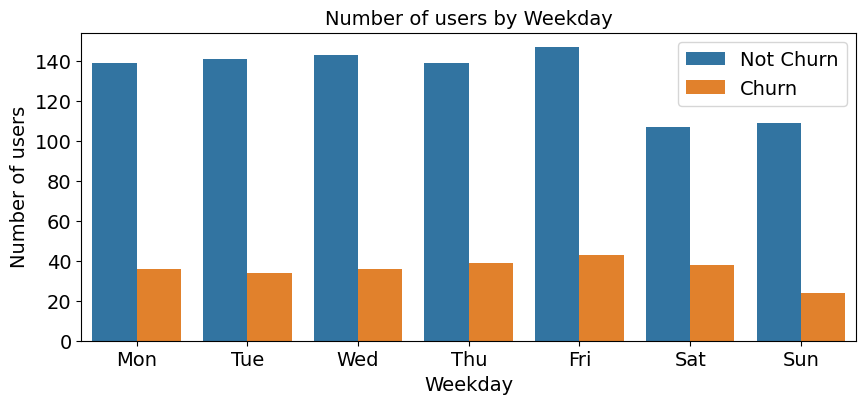

In [50]:
# Define a User Defined Function (UDF) to label churn users as 'Churn' or 'Not Churn'
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

# Select relevant columns, remove duplicates, and apply the 'churnUser' label
weekday_users_pd = df_sub.select(['userId', 'weekday', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

# Create a count plot to visualize the number of users by weekday, separated by churn status
fig = plt.figure(figsize=(10, 4))
sns.countplot(x="weekday", hue="churnUser", data=weekday_users_pd,
              hue_order=['Not Churn', 'Churn'])

# Customize the appearance of the plot
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label the axes and set the font size for better readability
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Number of users", fontsize=14)

# Set the plot title
plt.title("Number of users by Weekday", fontsize=14)

# Customize the x-axis ticks to show the days of the week (Mon, Tue, etc.)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Display the legend with appropriate font size
plt.legend(loc='best', fontsize=14);

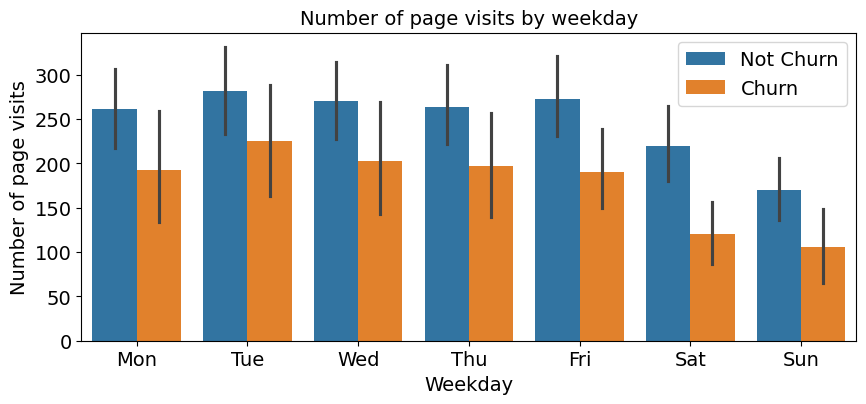

In [51]:
# Define a User Defined Function (UDF) to label churn users as 'Churn' or 'Not Churn'
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

# Group the data by 'userId' and 'weekday', calculate the total number of page visits,
# and the maximum churn status per user per weekday. Apply the churn label UDF.
weekday_usage_pd = df_sub.groupBy(['userId', 'weekday']).agg(count('page'), max('churnUser'))\
    .withColumn('max(churnUser)', func_churn_label('max(churnUser)'))\
    .toPandas()

# Create a bar plot to visualize the number of page visits by weekday, split by churn status
fig = plt.figure(figsize=(10, 4))
sns.barplot(x="weekday", y="count(page)", hue="max(churnUser)", data=weekday_usage_pd,
            hue_order=['Not Churn', 'Churn'])

# Customize the appearance of the plot
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label the axes and set the font size for better readability
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)

# Set the plot title
plt.title("Number of page visits by weekday", fontsize=14)

# Customize the x-axis ticks to show the days of the week (Mon, Tue, etc.)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Display the legend with appropriate font size
plt.legend(loc='best', fontsize=14);

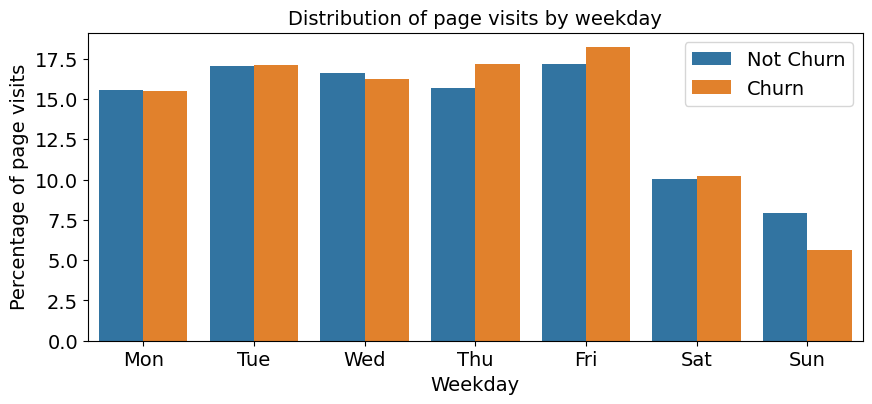

In [52]:
# Create a UDF (User Defined Function) to label churn status: 'Churn' if the churned value is 1, otherwise 'Not Churn'
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

# Convert the 'churnUser' column to the corresponding 'Churn' or 'Not Churn' label
# and convert the resulting DataFrame to a Pandas DataFrame
weekday_usage_pd = df_sub.withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

# Group the data by churn status, then count the occurrences of each weekday for each churn status.
# The result is normalized to give the percentage of page visits for each churn status per weekday.
weekday_usage_pd = weekday_usage_pd.groupby(['churnUser'])['weekday']\
    .value_counts(normalize=True).rename('percentage').mul(100).reset_index()

# Create a figure for the plot with a specified size
fig = plt.figure(figsize=(10, 4))

# Use Seaborn's barplot to visualize the percentage of page visits by weekday, split by churn status
# Set the hue to differentiate between 'Churn' and 'Not Churn' users
sns.barplot(x="weekday", y="percentage", hue="churnUser", data=weekday_usage_pd,
              hue_order=['Not Churn', 'Churn'])  # Ensure the correct order of hue labels

# Customize the x and y axis font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label the x and y axes and set their font size
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Percentage of page visits", fontsize=14)

# Set the correct weekday labels on the x-axis (from 0 to 6, which correspond to Mon-Sun)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Set the title of the plot and adjust the font size
plt.title("Distribution of page visits by weekday", fontsize=14)

# Add a legend to the plot to distinguish between 'Not Churn' and 'Churn'
plt.legend(loc='best', fontsize=14)

### Churn and level

Text(0.5, 1.0, 'Churn rate and user level')

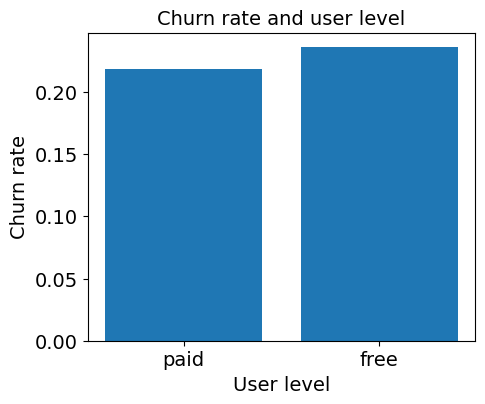

In [53]:
# Group data by 'level' (user level) and calculate the number of users and the number of churns for each level.
levels = df_sub.select(['userId', 'level', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('level')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))  # Count users and sum churns

# Convert the Spark DataFrame into a Pandas DataFrame for easier plotting
levels_df = levels.toPandas()

# Create a bar plot to visualize the churn rate by user level
plt.figure(figsize=(5,4))  # Set the figure size for the plot
plt.bar(levels_df['level'], levels_df['num_churns'] / levels_df['num_users'])  # Plot churn rate

# Customize the plot's x and y axis tick font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label the x and y axes and adjust the font size
plt.xlabel("User level", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)

# Set the title of the plot
plt.title("Churn rate and user level", fontsize=14)

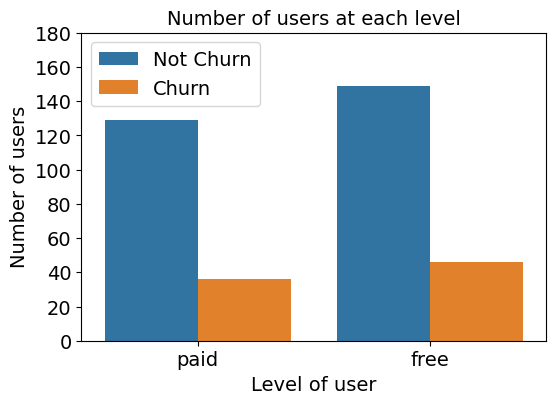

In [54]:
# Create a user-defined function (UDF) to label churn status
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

# Select relevant columns ('userId', 'level', 'churnUser'), remove duplicates,
# and apply the 'churnUser' label based on the churn status (1 -> 'Churn', 0 -> 'Not Churn')
level_users_pd = df_sub.select(['userId', 'level', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()  # Convert the DataFrame to Pandas for visualization

# Create a figure to plot the number of users at each level, categorized by churn status
fig = plt.figure(figsize=(6, 4))  # Set the figure size for the plot
sns.countplot(x="level", hue="churnUser", data=level_users_pd,
#                palette=['steelblue', 'orange'], ci=None,
)  # Plot the number of users at each level, with different hues for churn and not churn

# Set y-axis limits to restrict the height of the bars (for better visualization)
plt.ylim(0, 180)

# Customize the plot's x and y axis tick font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label the x and y axes and adjust the font size
plt.xlabel("Level of user", fontsize=14)
plt.ylabel("Number of users", fontsize=14)

# Set the title of the plot
plt.title("Number of users at each level", fontsize=14)

# Add a legend to differentiate between churned and non-churned users
plt.legend(loc='best', fontsize=14)

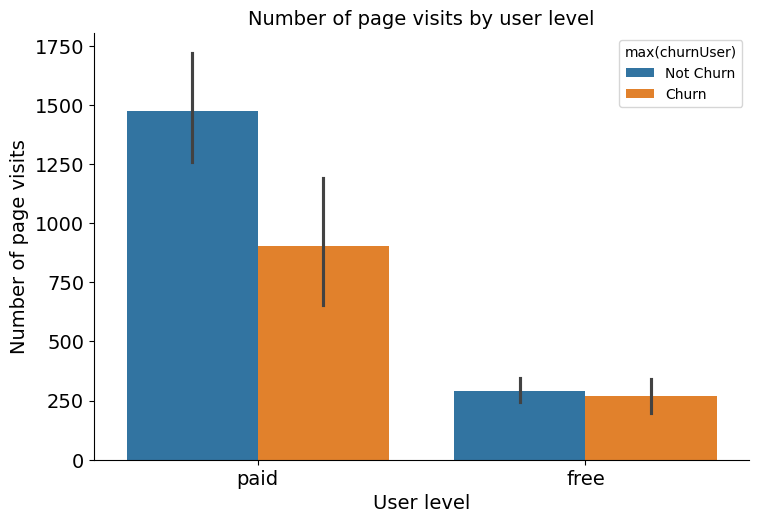

In [55]:
# Create a user-defined function (UDF) to label churn status
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

# Group the data by 'userId' and 'level', then calculate the number of page visits ('count(page)')
# and the maximum churn status for each user within each level.
# Apply the UDF to label the churn status as 'Churn' or 'Not Churn'
level_usage_pd = df_sub.groupBy(['userId', 'level']).agg(count('page'), max('churnUser'))\
    .withColumn('max(churnUser)', func_churn_label('max(churnUser)'))\
    .toPandas()  # Convert to Pandas DataFrame for visualization

# Create a user-defined function (UDF) to label churn status
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

# Group the data by 'userId' and 'level', then calculate the number of page visits ('count(page)')
# and the maximum churn status for each user within each level.
# Apply the UDF to label the churn status as 'Churn' or 'Not Churn'
level_usage_pd = df_sub.groupBy(['userId', 'level']).agg(count('page'), max('churnUser'))\
    .withColumn('max(churnUser)', func_churn_label('max(churnUser)'))\
    .toPandas()  # Convert to Pandas DataFrame for visualization

# Create a categorical plot to visualize the number of page visits by user level, split by churn status
sns.catplot(
    x="level",
    y="count(page)",
    hue="max(churnUser)",
    data=level_usage_pd,
    kind="bar",
    aspect=1.5,
    legend_out=False,  # Keep legend inside the plot
)

# Customize the plot by setting font size for axis labels and ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label the axes
plt.xlabel("User level", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)

# Set the title of the plot
plt.title("Number of page visits by user level", fontsize=14)

# Display the plot
plt.show()

> The ratio of free users to the number of paid users is more or less equal and in addition free users are a little closer to churn

### Churn and page events

In [56]:
# Group the data by 'userId' to analyze activity at the user level, and pivot on 'page' to create columns for each page type.
pages = df_sub.groupBy(['userId']).pivot('page').count().fillna(0)

# Convert the Spark DataFrame into a Pandas DataFrame for easier manipulation and visualization.
pages_df = pages.toPandas()

# Rename the column 'Cancellation Confirmation' to 'Churn' for better readability,
# as this page indicates user churn behavior.
pages_df = pages_df.rename(columns={"Cancellation Confirmation": "Churn"})

# Display the first few rows of the resulting DataFrame to inspect the data.
pages_df.head()

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,4,6,46,59,0,0,21,4,12,80,24,2048,4,2,10,0,1,26,95,4
1,74,4,43,80,0,0,31,1,13,84,25,2400,22,1,17,1,2,25,135,3
2,87,1,27,19,1,1,1,0,8,56,19,767,50,0,8,0,1,5,32,7
3,131,5,26,51,0,0,15,4,13,54,18,1564,5,2,10,2,1,20,72,1
4,126,7,33,72,0,0,22,2,15,119,39,2577,35,4,17,0,1,21,135,3


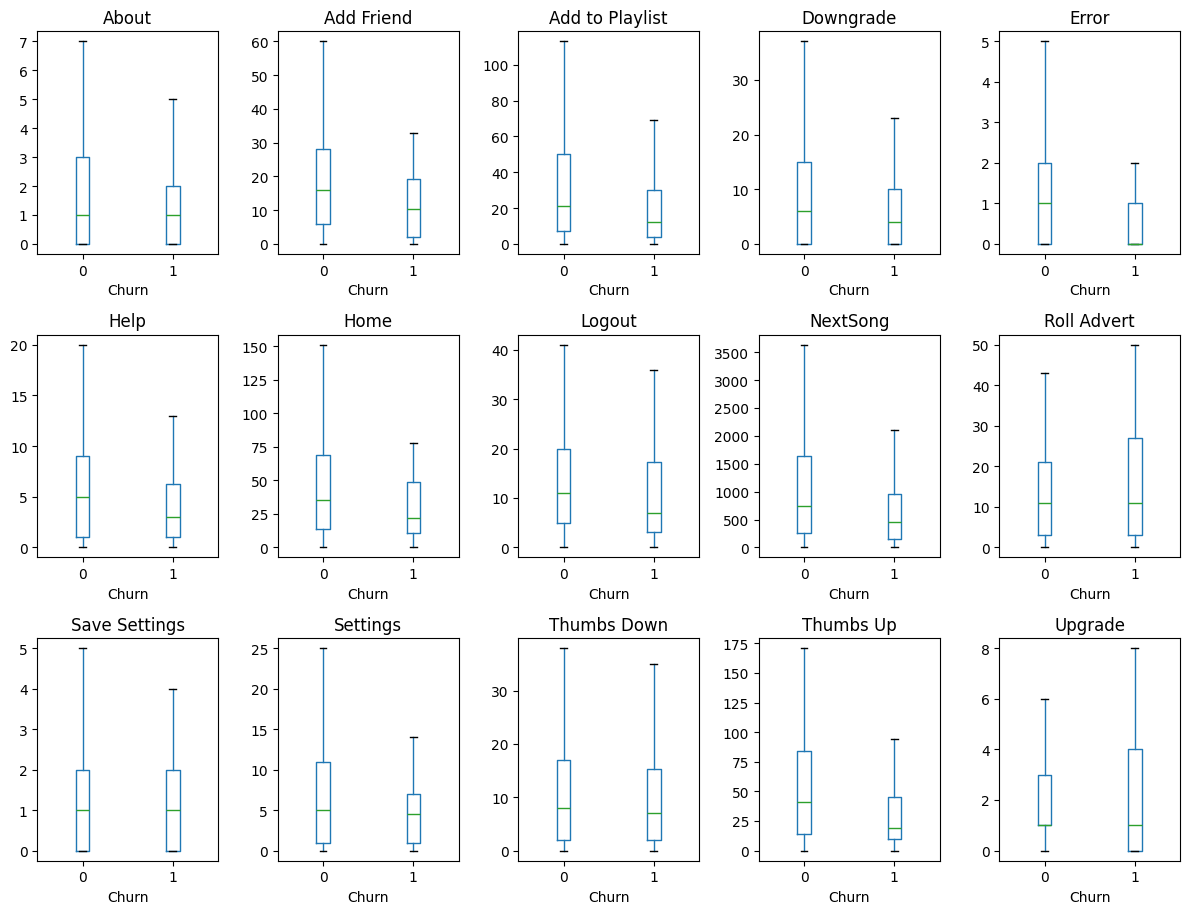

In [57]:
# Create a figure with a specified size to accommodate multiple subplots.
fig = plt.figure(figsize=(12, 12))

# Define a list of columns of interest, representing different page interactions,
# for which boxplots will be created.
cols_interest = ['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home',
                 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Thumbs Down',
                 'Thumbs Up', 'Upgrade']

# Loop through each column in the list of columns of interest.
for i, coln in enumerate(cols_interest):
    # Add a subplot for each column in a 4x5 grid layout.
    ax = fig.add_subplot(4, 5, i+1)

    # Create a boxplot for the current column (`coln`), grouped by the 'Churn' column.
    # The boxplot excludes outliers (`showfliers=False`) for clarity and hides the grid.
    pages_df.boxplot(coln, ax=ax, grid=False, by='Churn', showfliers=False)

# Remove the overall figure title added automatically by pandas `boxplot`.
fig.suptitle('')

# Adjust the layout to ensure that subplots don't overlap.
plt.tight_layout()

> The results also show that churn users exhibit lower activity level (measured by the number of page events) than no-churn users. Compared to non churn users, churn users have added comparatively less number of friends, added less playlists, asked for less help, listened less songs, and given less thumbs up than thumbs down. Notably, different to the predictive model, churn users have also reported fewer errors, which, when one thinks about it, most be true as churn users tend to use Spotify much less and thus have fewer opportunities to report errors

In [58]:
# Replace numerical values in the 'Churn' column with string labels for better readability.
pages_df['Churn'] = pages_df['Churn'].replace({1: "Churn", 0: "Not Churn"})

# Drop the 'Cancel' column from the DataFrame as it's no longer needed for analysis.
pages_df = pages_df.drop('Cancel', axis=1)

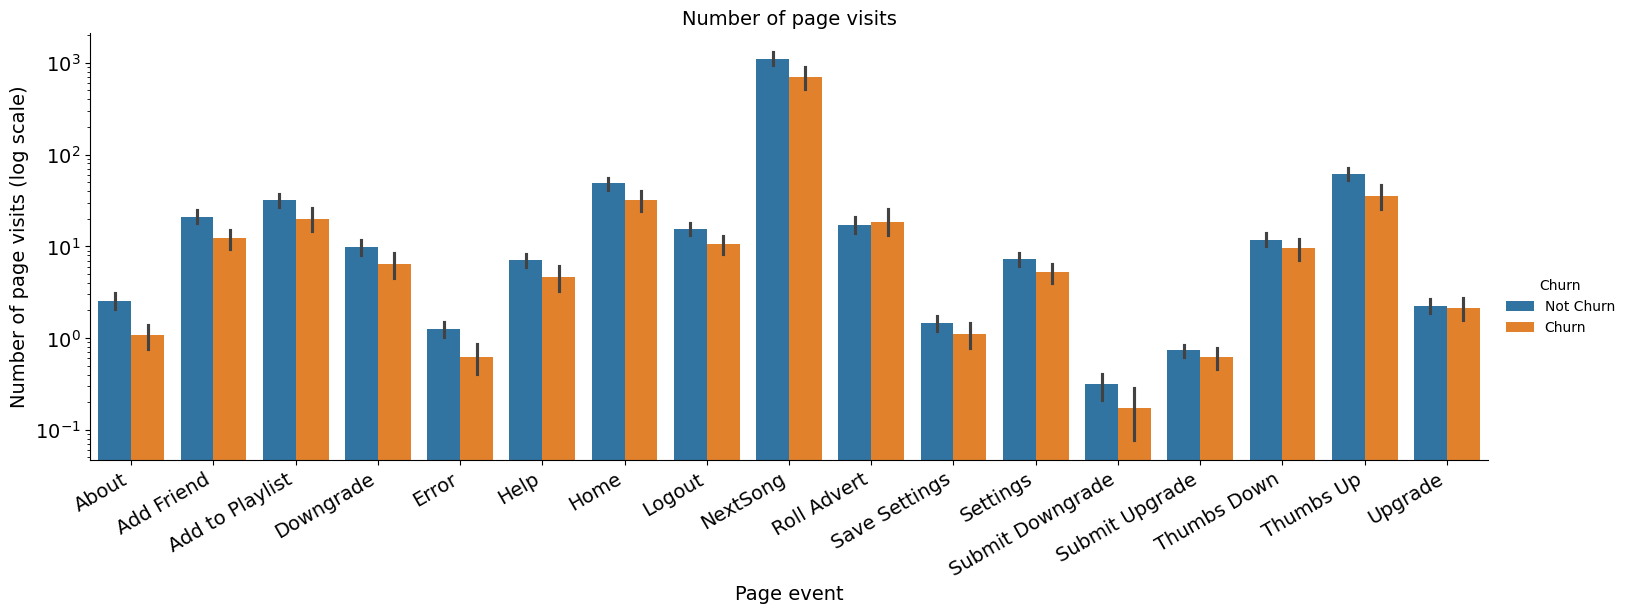

In [59]:
# Transform the DataFrame from a wide format to a long format using `pd.melt` for easier plotting.
page_events_pd = pd.melt(
    pages_df, id_vars=['userId', 'Churn'],
    value_vars=list(pages_df.columns[1:].drop('Churn')),  # Exclude 'Churn' column from melting.
    var_name='page',  # Name of the new column representing the page events.
    value_name='number_visits'  # Name of the new column representing visit counts.
).reset_index()

# Use seaborn's catplot to create a bar plot.
g = sns.catplot(
    x="page", y="number_visits", hue="Churn", data=page_events_pd,
    kind="bar", aspect=3, legend=True
)

# Set y-axis to log scale
plt.yscale('log')

# Customize plot appearance.
g.set_xticklabels(rotation=30, ha='right', fontsize=14)  # Rotate x-axis labels for better readability.
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)  # Add x-axis label.
plt.ylabel("Number of page visits (log scale)", fontsize=14)  # Add y-axis label.
plt.title("Number of page visits", fontsize=14)  # Add plot title.

# Display the plot.
plt.show()

### Analyzing the time from downgrading to churn for users who churned

Text(0.5, 1.0, 'Distribution of time from downgrade to churn')

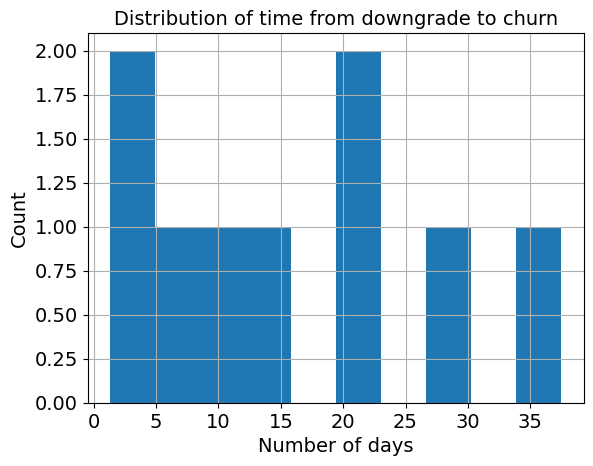

In [60]:
# Filter the DataFrame to include only users who churned and were in a downgrade phase.
downgrade_to_churn = df_sub.filter(
    (df_sub['churnUser'] == 1) & (df_sub['pageDowngradePhase'] == 1)
)\
    .groupBy(['userId'])\
    .agg(max('ts') - min('ts'))\
    .withColumnRenamed('(max(ts) - min(ts))', 'timeDownToChurn')  # Rename the column to a more descriptive name.

# Convert the time from milliseconds to hours for better readability.
hours_to_churn = downgrade_to_churn.withColumn(
    "hourDownToChurn", downgrade_to_churn["timeDownToChurn"] / 1000 / 3600  # Convert milliseconds to hours.
).select(['userId', 'hourDownToChurn'])  # Select only userId and calculated hours to churn.

# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting.
hours_to_churn_pd = hours_to_churn.toPandas()

# Create a histogram of the time (in days) from downgrade to churn for visualization.
(hours_to_churn_pd['hourDownToChurn'] / 24).hist()  # Convert hours to days for better interpretability.
plt.xticks(fontsize=14)  # Set font size for x-axis tick labels.
plt.yticks(fontsize=14)  # Set font size for y-axis tick labels.
plt.xlabel("Number of days", fontsize=14)  # Label for the x-axis.
plt.ylabel("Count", fontsize=14)  # Label for the y-axis.
plt.title("Distribution of time from downgrade to churn", fontsize=14)  # Title for the plot.

# Feature Engineering
In this section, I would like to construct features that seem helpful for training my model on. To begin with, I will carry out pilot study using the smallest sample to the whole dataset. Then, I will operate with the code on full data set.

In [61]:
# Set the desired sample size
desired_sample_size = 250

# Get a list of distinct user IDs
distinct_users = df.select("userId").distinct().rdd.flatMap(lambda x: x).collect()

# Determine whether we need to sample or if we can use all users
if len(distinct_users) > desired_sample_size:
    # Randomly select a subset of users without replacement
    sampled_users = random.sample(distinct_users, desired_sample_size)
else:
    # If there are fewer users than the sample size, select all users
    sampled_users = distinct_users

# Create a filtered DataFrame with the sampled users
df_feature = df.filter(df['userId'].isin(sampled_users))

# Output the number of unique user IDs in the subset to confirm
unique_users_count = df_feature.select("userId").distinct().count()
print(f"Number of unique user IDs in the subset: {unique_users_count}")

Number of unique user IDs in the subset: 225


## Develop features based on user needs

- page-Cancellation Confirmation: Churn (binary)
- registration and ts: The number of seconds since registration
- gender: Gender, binary, "M"->1, "F"->0
- level: The most recent user level, where "paid" -> 1 and "free" -> 0 (binary)
- artist: The total number of distinct musicians the user has heard (int)
- length: The total amount of time spent listening to music (float)
- sessionId: The total amount of sessions (int)
- song: The user's overall musical selections (int)
- artist and song: Data on how many songs each artist has been listened to by the user (float)
- sessionId and ts: Time spent in each session statistics (float)
- Song and sessionId: Data on the quantity of songs played during a session (float)
- userAgent: Binary user agents
- page: Page events count (int)
- location: The state of the first mentioned place (binary)

In [62]:
df_feature.createOrReplaceTempView("df_feature_table")

### Identify churn events by creating a flag column

In [63]:
# Assign 1 if the event is "Cancellation Confirmation"; otherwise, assign 0.
churn_flag = df_feature.withColumn(
    "churned",
    F.when(df_feature["page"] == "Cancellation Confirmation", 1).otherwise(0)
)

# Aggregate churn information for each user
# Group by 'userId' and determine if the user has churned by checking the maximum churn flag.
user_churn = churn_flag.groupBy("userId").agg(
    F.max("churned").alias("churn")
)

# Calculate total number of users
num_users = user_churn.count()
print(f"{num_users} rows.")

# Compute churn rate by averaging the churn column, and convert it to a percentage
churn_rate = user_churn.select(F.avg("churn")).collect()[0][0] * 100
print(f"{round(churn_rate, 1)}% users churned.")

# Display the first few rows of the churn DataFrame to verify results
user_churn.show(5)

225 rows.
23.1% users churned.
+------+-----+
|userId|churn|
+------+-----+
|    74|    0|
|     4|    0|
|    45|    0|
|    87|    1|
|   131|    0|
+------+-----+
only showing top 5 rows



### Extract the most recent level for each user

In [64]:
# Create a mapping for levels: "paid" -> 1, other levels -> 0
level_map = F.udf(lambda level: 1 if level == "paid" else 0, IntegerType())

# Step 1: Order by timestamp in descending order
# Step 2: Drop duplicates to keep the latest level for each user
# Step 3: Apply the mapping to convert levels to integers
user_levels = (
    df_feature
    .orderBy(F.desc("ts"))
    .dropDuplicates(["userId"])
    .select("userId", "level")
    .withColumn("level", level_map("level").cast(IntegerType()))
)

# Print the total count of users and show a preview
num_rows = user_levels.count()
print(f"{num_rows} rows.")
user_levels.show(5)

225 rows.
+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



### Time since registration and gender distribution

In [65]:
# Calculate the time since registration and the gender distribution using SQL
time_gender_df = spark.sql(
    '''
    SELECT userId,
           (MAX(ts) - AVG(registration)) / 1000 / 3600 AS time_since_regi,
           AVG(CASE WHEN gender = 'M' THEN 1 ELSE 0 END) AS gender
    FROM df_feature_table
    GROUP BY userId
    '''
)

# Impute missing time_since_regi values with the mean
mean_time = time_gender_df.select(F.avg('time_since_regi')).first()[0]
time_gender_df = time_gender_df.fillna({'time_since_regi': mean_time})

# Print the number of rows and show a few records
print(f"Number of rows: {time_gender_df.count()}")
time_gender_df.show(5)

Number of rows: 225
+------+------------------+------+
|userId|   time_since_regi|gender|
+------+------------------+------+
|    74|1709.3630555555555|   0.0|
|     4|1507.1458333333333|   1.0|
|    45| 1945.996388888889|   0.0|
|    87|1419.0205555555556|   1.0|
|   131|2901.5980555555557|   1.0|
+------+------------------+------+
only showing top 5 rows



### Total duration, number of sessions, number of artists, and number of songs the user has listened to

In [66]:
# Calculate the number of unique artists, total length, number of sessions, unique songs, and number of page events
engagement_df = df_feature \
    .groupBy("userId") \
    .agg(
        # Count distinct artists
        F.countDistinct('artist').alias('num_artists_dist'),

        # Sum of song lengths
        F.sum('length').alias('tot_length'),

        # Count distinct sessions
        F.countDistinct('sessionId').alias('num_sessions'),

        # Count songs
        F.count('song').alias('num_songs'),

        # Count distinct songs
        F.countDistinct('song').alias('num_songs_dist'),

        # Count page events
        F.count('page').alias('num_events')
    )

# Print the number of rows and show a few records
print(f"Number of rows: {engagement_df.count()}")
engagement_df.show(5)

Number of rows: 225
+------+----------------+------------------+------------+---------+--------------+----------+
|userId|num_artists_dist|        tot_length|num_sessions|num_songs|num_songs_dist|num_events|
+------+----------------+------------------+------------+---------+--------------+----------+
|    74|            1557| 601865.1515599996|          23|     2400|          2071|      2887|
|     4|            1342|506140.04138000077|          22|     2048|          1799|      2442|
|    45|            1057|367138.22695999994|          16|     1484|          1350|      1776|
|    87|             622|193639.95913000012|          25|      767|           725|      1003|
|   131|            1100|389584.29663999996|          19|     1564|          1403|      1863|
+------+----------------+------------------+------------+---------+--------------+----------+
only showing top 5 rows



### Data showing how many songs each artist has been listened to by the user

In [67]:
# First, calculate the number of songs per artist for each user
songs_per_artist_df = df_feature \
    .filter(F.col('artist').isNotNull()) \
    .groupBy('userId', 'artist') \
    .agg(F.count('song').alias('num_songs'))

# Then, calculate the max, avg, and stddev of the number of songs per artist per user
per_artist_df = songs_per_artist_df \
    .groupBy('userId') \
    .agg(
        # Maximum number of songs per artist
        F.max('num_songs').alias('max_songs_per_artist'),

        # Average number of songs per artist
        F.avg('num_songs').alias('avg_songs_per_artist'),

        # Standard deviation of the number of songs per artist
        F.stddev_samp('num_songs').alias('std_songs_per_artist')
    )

# Fill any null values with 0
per_artist_df = per_artist_df.fillna(0)

# Print the number of rows and display the first few rows
print(f"Number of rows: {per_artist_df.count()}")
per_artist_df.show(5)

Number of rows: 225
+------+--------------------+--------------------+--------------------+
|userId|max_songs_per_artist|avg_songs_per_artist|std_songs_per_artist|
+------+--------------------+--------------------+--------------------+
|    74|                  19|  1.5414258188824663|  1.5504742691535534|
|     4|                  17|   1.526080476900149|  1.4803175947877196|
|    87|                   5|  1.2331189710610932|  0.6705175605661668|
|   131|                  17|  1.4218181818181819|  1.1945723337804353|
|   126|                  24|  1.5684723067559343|  1.6703050377998638|
+------+--------------------+--------------------+--------------------+
only showing top 5 rows



### Time spent and song count statistics for each session

In [68]:
# Step 1: Calculate the number of songs and the session time for each user-session pair
session_data = df_feature \
    .groupBy('userId', 'sessionId') \
    .agg(
        # Calculate the time spent in each session (in seconds)
        ((F.max('ts') - F.min('ts')) / 1000).alias('time'),

        # Count the number of songs per session
        F.count('song').alias('num_songs')
    )

# Step 2: Calculate max, avg, and stddev for the number of songs and session time per user
per_session_df = session_data \
    .groupBy('userId') \
    .agg(
        # Maximum number of songs in a session
        F.max('num_songs').alias('max_songs_per_session'),

        # Average number of songs in a session
        F.avg('num_songs').alias('avg_songs_per_session'),

        # Standard deviation of the number of songs in a session
        F.stddev_samp('num_songs').alias('std_songs_per_session'),

        # Maximum session time
        F.max('time').alias('max_time_per_session'),

        # Average session time
        F.avg('time').alias('avg_time_per_session'),

        # Standard deviation of the session time
        F.stddev_samp('time').alias('std_time_per_session')
    )

# Step 3: Fill any null values with 0
per_session_df = per_session_df.fillna(0)

# Step 4: Print the number of rows and display the first few rows
print(f"Number of rows: {per_session_df.count()}")
per_session_df.show(5)

Number of rows: 225
+------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+
|userId|max_songs_per_session|avg_songs_per_session|std_songs_per_session|max_time_per_session|avg_time_per_session|std_time_per_session|
+------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+
|    74|                  275|   104.34782608695652|    99.04847697220708|             67288.0|  25961.304347826088|  24732.614346307226|
|     4|                  439|     93.0909090909091|   126.27517536483532|            110175.0|   22760.31818181818|  31560.615475298535|
|    45|                  373|                92.75|   114.86426772499792|             92748.0|           22787.125|   28660.88659683553|
|    87|                   93|                30.68|   26.671957808404937|             24614.0|             7537.24|   6693.637154542115|
|   126|      

### Determine each user-agent's usage

In [69]:
# Step 1: Create a new column to extract the user agent
def extract_user_agent(user_agent_string):
    """Extracts the user agent type from the user agent string."""
    # Split and clean the user agent string
    parts = user_agent_string.split('(')
    if len(parts) > 1:
        return "user_agent_" + parts[1].replace(";", " ").split(" ")[0]
    return "unknown"

# Registering the function as a UDF (User Defined Function)
extract_user_agent_udf = F.udf(extract_user_agent)

# Step 2: Add a new column 'userAgent' and calculate user agent usage
user_agent_usage_df = df_feature \
    .withColumn("userAgent", extract_user_agent_udf("userAgent")) \
    .groupBy("userId", "userAgent") \
    .agg(
        F.count("userAgent").alias("user_agent_usage")  # Count the occurrences of each user-agent per user
    )

# Step 3: Calculate the total user-agent usage per user (using window functions)
window_spec = Window.partitionBy("userId")
user_agent_usage_with_total_df = user_agent_usage_df \
    .withColumn("total_usage", F.sum("user_agent_usage").over(window_spec)) \
    .withColumn("normalized_usage", F.col("user_agent_usage") / F.col("total_usage"))

# Step 4: Pivot the data to create one column for each user agent type
pivoted_agents_df = user_agent_usage_with_total_df \
    .groupBy("userId") \
    .pivot("userAgent") \
    .agg(F.sum("normalized_usage")) \
    .fillna(0)

# Step 5: Show the result
print(f"Number of rows: {pivoted_agents_df.count()}")
pivoted_agents_df.show(5)

Number of rows: 225
+------+--------------------+------------------+--------------+---------------------+---------------+-----------------+
|userId|user_agent_Macintosh|user_agent_Windows|user_agent_X11|user_agent_compatible|user_agent_iPad|user_agent_iPhone|
+------+--------------------+------------------+--------------+---------------------+---------------+-----------------+
|    10|                 1.0|               0.0|           0.0|                  0.0|            0.0|              0.0|
|   100|                 0.0|               1.0|           0.0|                  0.0|            0.0|              0.0|
|100001|                 1.0|               0.0|           0.0|                  0.0|            0.0|              0.0|
|100002|                 0.0|               1.0|           0.0|                  0.0|            0.0|              0.0|
|100003|                 0.0|               1.0|           0.0|                  0.0|            0.0|              0.0|
+------+------------

### Determine the number and percentage of each user-generated page event

In [70]:
# Step 1: Define the list of pages to exclude
exclude_pages = ['Cancel', 'Downgrade', 'Cancellation Confirmation', 'Upgrade']

# Step 2: Define a function to format page names
def format_page_name(page_name):
    """Formats the page name to lowercase with underscores instead of spaces."""
    return "page_" + page_name.replace(" ", "_").lower()

# Register the function as a UDF
format_page_name_udf = F.udf(format_page_name, StringType())

# Step 3: Filter out pages to exclude and apply the formatting function
filtered_pages_df = df_feature.filter(~df_feature['page'].isin(exclude_pages)) \
    .withColumn("formatted_page", format_page_name_udf("page"))

# Step 4: Aggregate and pivot the data
pivoted_pages_df = filtered_pages_df \
    .groupBy("userId") \
    .pivot("formatted_page") \
    .agg(F.count("page")) \
    .fillna(0)

# Step 5: Calculate the thumbs up to thumbs down ratio (handling division by zero)
pivoted_pages_df = pivoted_pages_df.withColumn(
    "page_up_down_ratio",
    pivoted_pages_df["page_thumbs_up"] / (pivoted_pages_df["page_thumbs_down"] + 0.1)
)

# Step 6: Display the results
print(f"Number of rows: {pivoted_pages_df.count()}")
pivoted_pages_df.show(2)

Number of rows: 225
+------+----------+---------------+--------------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------------+
|userId|page_about|page_add_friend|page_add_to_playlist|page_error|page_help|page_home|page_logout|page_nextsong|page_roll_advert|page_save_settings|page_settings|page_submit_downgrade|page_submit_upgrade|page_thumbs_down|page_thumbs_up|page_up_down_ratio|
+------+----------+---------------+--------------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------------+
|     4|         6|             46|                  59|         4|       12|       80|         24|         2048|               4|                 2|           10|                    0|                  1|    

In [71]:
# Step 1: Calculate the total of all columns excluding 'userId', 'page_up_down_ratio', and 'total'
columns_to_include = [coln for coln in pages.columns if coln not in ['userId', 'page_up_down_ratio']]
total_column_expr = sum(F.col(coln) for coln in columns_to_include)

# Add the 'total' column
pages_with_total = pages.withColumn('total', total_column_expr)

# Step 2: Create fraction columns for each page metric relative to the 'total'
for col_name in columns_to_include:
    if col_name != 'userId':
        # Generate a new name for the fraction column
        frac_col_name = 'frac_' + col_name
        # Add a new column that stores the fraction of the total
        pages_with_total = pages_with_total.withColumn(frac_col_name, F.col(col_name) / F.col('total'))

# Step 3: Drop the 'total' column as it is no longer needed
pages_with_total = pages_with_total.drop('total')

# Step 4: Print the number of rows and show the fraction columns
print(f"Number of rows: {pages_with_total.count()}")
pages_with_total.select([col for col in pages_with_total.columns if 'frac' in col]).show(2)

Number of rows: 225
+--------------------+--------------------+--------------------+-----------+------------------------------+--------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|          frac_About|     frac_Add Friend|frac_Add to Playlist|frac_Cancel|frac_Cancellation Confirmation|      frac_Downgrade|          frac_Error|           frac_Help|          frac_Home|         frac_Logout|     frac_NextSong|    frac_Roll Advert|  frac_Save Settings|       frac_Settings|frac_Submit Downgrade| frac_Submit Upgrade|    frac_Thumbs Down|      frac_Thumbs Up|        frac_Upgrade|
+--------------------+--------------------+--------------------+-----------+------------------------------+--------------------+--------------------+--------------------+----------

### Locate each user's initial specified location region

In [72]:
# Step 1: Define user-defined functions (UDFs) for processing location
def extract_state_code(location_str):
    """Extract the state code from a location string."""
    return location_str.split(', ')[1].split('-')[0]

def format_location_name(location_str):
    """Format the location string to be used as a column name."""
    return "location_" + location_str.replace(" ", "_").lower()

# Register UDFs
extract_state_udf = F.udf(extract_state_code, StringType())
format_location_udf = F.udf(format_location_name, StringType())

# Step 2: Process the location column
locations_processed = df_feature.withColumn('location_code', extract_state_udf(df_feature['location'])) \
    .select(['userId', 'location_code']) \
    .dropDuplicates(subset=['userId'])

# Step 3: Convert `region` pandas DataFrame to Spark DataFrame
region_spark_df = spark.createDataFrame(region)  # Convert pandas to Spark DataFrame

# Check the schema of the region DataFrame
region_spark_df.printSchema()

# Step 4: Join with the `region` DataFrame to get location-related information
locations_with_region = locations_processed.join(
    region_spark_df,  # Join with the Spark DataFrame
    locations_processed['location_code'] == region_spark_df['State Code'],  # Ensure correct column references
    how='left'
).select(['userId', F.col("Division").alias("location_name")])

# Step 5: Format the location names
locations_with_region = locations_with_region.withColumn('location_name', format_location_udf('location_name'))

# Step 6: Group and pivot the data
locations_summary = locations_with_region.groupBy('userId').pivot('location_name').agg(F.count('location_name')).fillna(0)

# Step 7: Display the result
print(f"Number of rows: {locations_summary.count()}")
locations_summary.show(2)

root
 |-- State: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Division: string (nullable = true)

Number of rows: 225
+------+---------------------------+---------------------------+------------------------+-----------------+--------------------+----------------+-----------------------+---------------------------+---------------------------+
|userId|location_east_north_central|location_east_south_central|location_middle_atlantic|location_mountain|location_new_england|location_pacific|location_south_atlantic|location_west_north_central|location_west_south_central|
+------+---------------------------+---------------------------+------------------------+-----------------+--------------------+----------------+-----------------------+---------------------------+---------------------------+
|100004|                          0|                          0|                       1|                0|                   0|           

### Integrate engineered features

In [73]:
# Step 1: Join user_churn with user_levels based on 'userId' column
combined_data = user_churn.join(user_levels, ['userId'], how='left')

# Step 3: Add the `time_gender` data
combined_data = combined_data.join(time_gender_df, ['userId'], how='left')

# Step 4: Add the `engagement` data
combined_data = combined_data.join(engagement_df, ['userId'], how='left')

# Step 5: Add the `per_artist` data
combined_data = combined_data.join(per_artist_df, ['userId'], how='left')

# Step 6: Add the `per_session` data
combined_data = combined_data.join(per_session_df, ['userId'], how='left')

# Step 7: Add the `agents` data
combined_data = combined_data.join(pivoted_agents_df, ['userId'], how='left')

# Step 8: Add the `pages` data
combined_data = combined_data.join(pivoted_pages_df, ['userId'], how='left')

# Step 9: Add the `locations` data
combined_data = combined_data.join(locations_summary, ['userId'], how='left')

# Step 3: Display the first few rows of the final dataset
combined_data.show(5)

+------+-----+-----+------------------+------+----------------+------------------+------------+---------+--------------+----------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+---------------------+---------------+-----------------+----------+---------------+--------------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------------+---------------------------+---------------------------+------------------------+-----------------+--------------------+----------------+-----------------------+---------------------------+---------------------------+
|userId|churn|level|   time_since_regi|gender|num_artists_dist|        tot_length|num_sessions|num_s

## Examine multicollinearity

In [74]:
# Convert to pandas DataFrame
dataset_pd = combined_data.toPandas()

# Compute the correlation matrix
corr_matrix = dataset_pd.corr()

# Identify features with a correlation greater than or equal to 0.5 with any other feature
highly_corr_cols = [
    coln for coln in corr_matrix.columns if any(corr_matrix[coln].abs() >= 0.5) and corr_matrix[coln].abs().sum() > 0
]

# Find pairs of features with a correlation higher than 0.8 to determine which features to remove
remove_cols = []
for coln in highly_corr_cols:
    correlated_with = corr_matrix[coln].iloc[corr_matrix.columns.get_loc(coln)+1:]
    if any(correlated_with >= 0.8):
        remove_cols.append(coln)

# Output the features to remove and the features to keep
print(f"Features with high correlation (to remove): {remove_cols}\n")
cols_to_keep = [coln for coln in dataset_pd.columns if coln not in remove_cols]
print(f"Features to retain: {cols_to_keep}")

Features with high correlation (to remove): ['num_artists_dist', 'tot_length', 'num_sessions', 'num_songs', 'num_songs_dist', 'num_events', 'max_songs_per_artist', 'avg_songs_per_artist', 'std_songs_per_artist', 'max_songs_per_session', 'avg_songs_per_session', 'std_songs_per_session', 'max_time_per_session', 'avg_time_per_session', 'page_add_friend', 'page_add_to_playlist', 'page_help', 'page_home', 'page_logout', 'page_nextsong', 'page_settings']

Features to retain: ['userId', 'churn', 'level', 'time_since_regi', 'gender', 'std_time_per_session', 'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone', 'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_up_down_ratio', 'location_east_north_central', 'location_east_south_central', 'location_middle_atlantic', 'location_mountain', 'location_new_england', 'l

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5]),
 [Text(0, 0.5, 'churn'),
  Text(0, 1.5, 'level'),
  Text(0, 2.5, 'time_since_regi'),
  Text(0, 3.5, 'gender'),
  Text(0, 4.5, 'std_time_per_session'),
  Text(0, 5.5, 'page_about'),
  Text(0, 6.5, 'page_error'),
  Text(0, 7.5, 'page_roll_advert'),
  Text(0, 8.5, 'page_save_settings'),
  Text(0, 9.5, 'page_submit_downgrade'),
  Text(0, 10.5, 'page_submit_upgrade'),
  Text(0, 11.5, 'page_thumbs_down'),
  Text(0, 12.5, 'page_thumbs_up'),
  Text(0, 13.5, 'page_up_down_ratio'),
  Text(0, 14.5, 'location_east_north_central'),
  Text(0, 15.5, 'location_east_south_central'),
  Text(0, 16.5, 'location_middle_atlantic'),
  Text(0, 17.5, 'location_mountain'),
  Text(0, 18.5, 'location_new_england'),
  Text(0, 19.5, 'location_pacific'),
  Text(0, 20.5, 'location_south_atlantic'),
  Text(0, 21.5, 'location_west_north_central'),
  Text(0, 

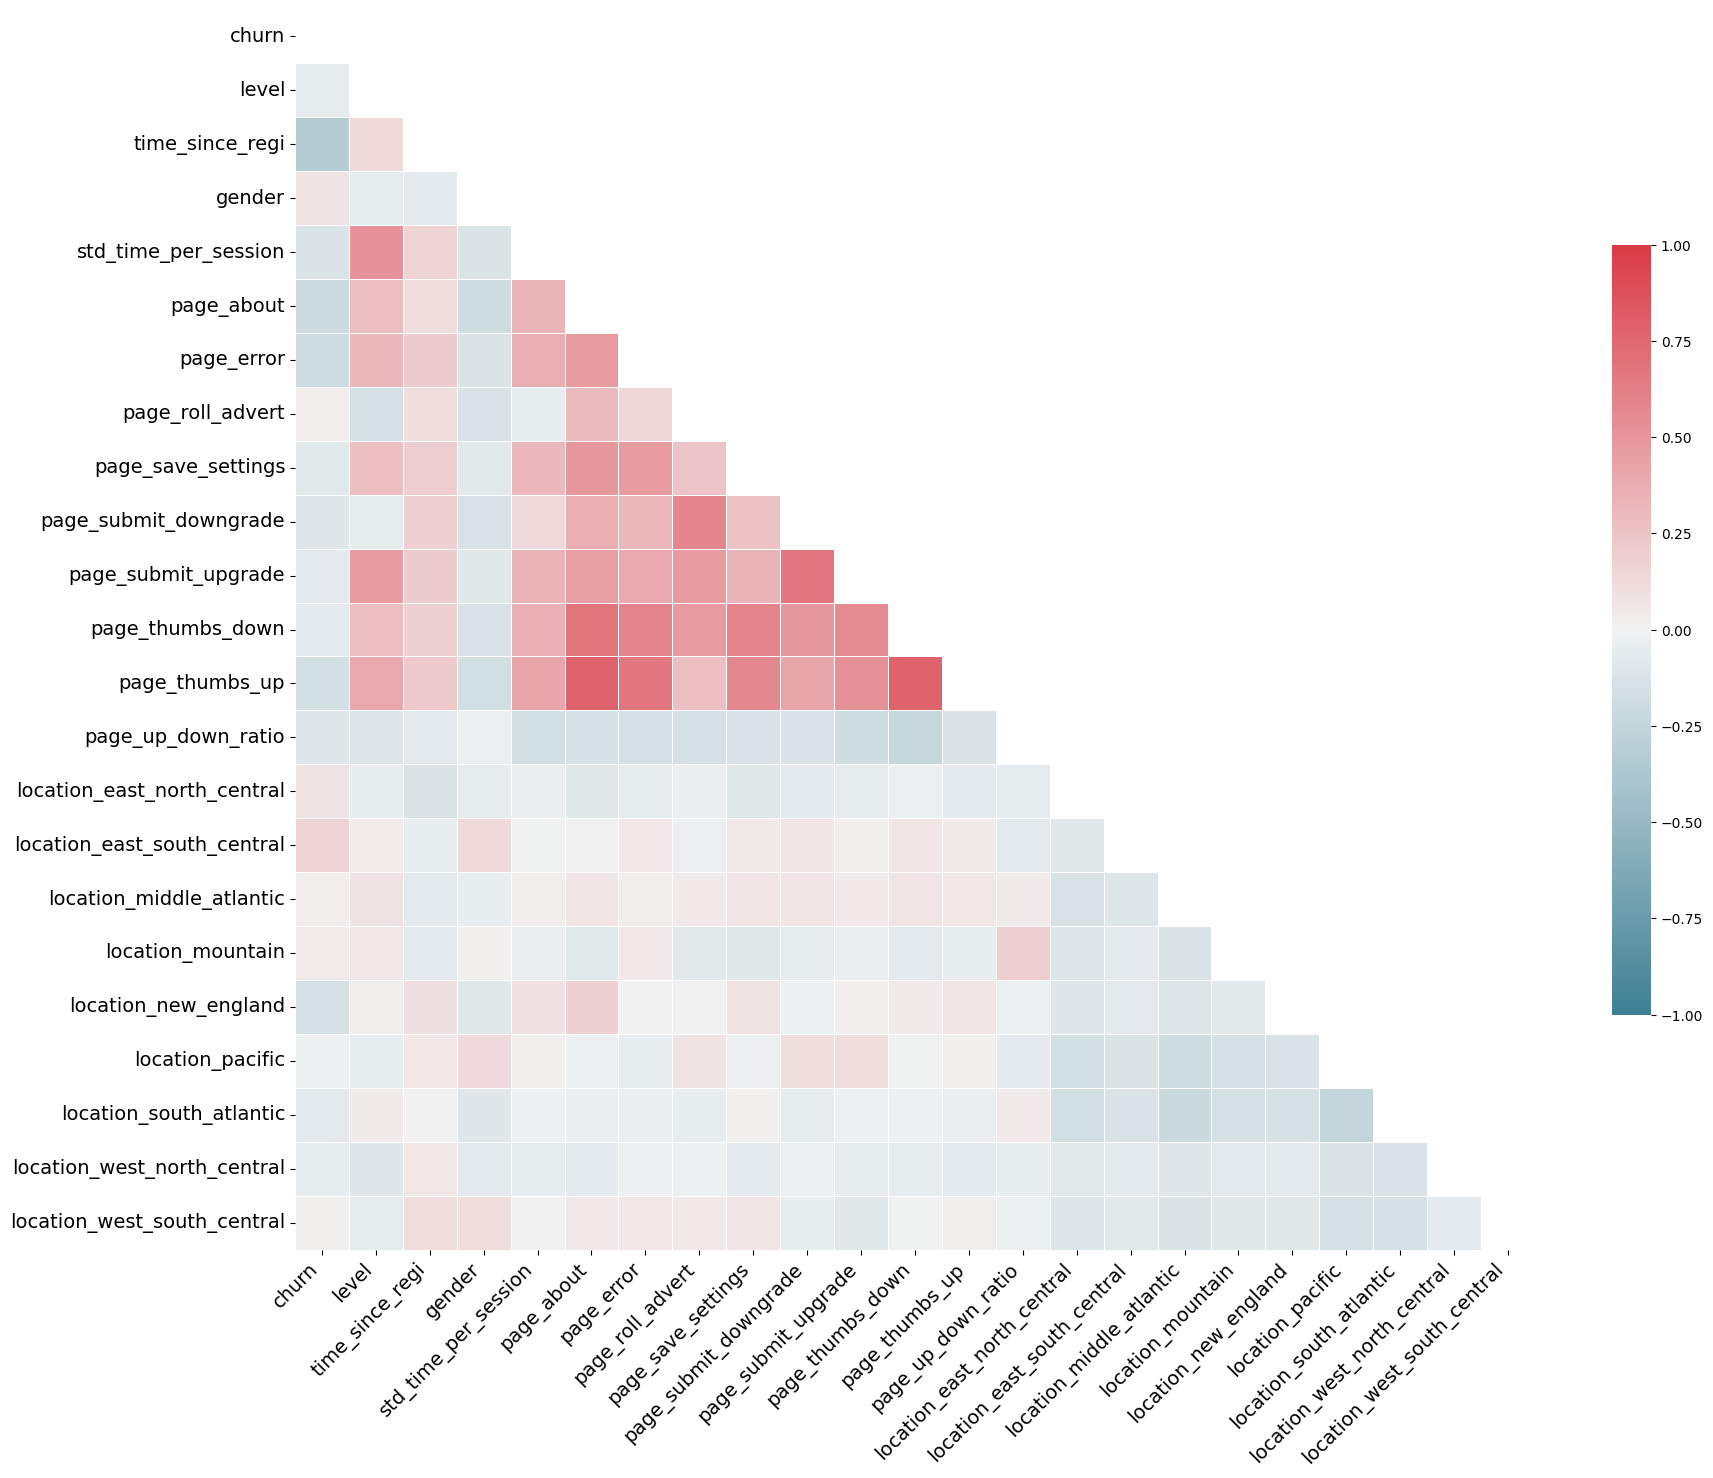

In [75]:
# Filter out features related to 'user_agent' and 'userId'
filtered_cols = [coln for coln in cols_to_keep if 'user_agent' not in coln and 'userId' not in coln]

# Compute the correlation matrix for the filtered features
correlation_matrix = dataset_pd[filtered_cols].corr()

# Create a mask to hide the upper triangle (to avoid duplicate information in the heatmap)
upper_triangle_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Initialize a figure for visualization
fig, ax = plt.subplots(figsize=(20, 20))

# Define a color palette for the heatmap
color_map = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the upper triangle mask and customized properties
sns.heatmap(
    correlation_matrix,
    mask=upper_triangle_mask,
    cmap=color_map,
    center=0,
    vmin=-1, vmax=1,
    annot=False,  # You can toggle this on if you want to show values
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .5},
    xticklabels=filtered_cols,
    yticklabels=filtered_cols,
    ax=ax
)

# Customize the appearance of tick labels
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

> The remaining associations are not very strong (correlation coefficient >=0.8)

## Transforming features
In summary, adjust features to approximate normal distributions.

### Analyze feature allocations

In [76]:
# Reset the dataset

# Step 1: Join user_churn with user_levels based on 'userId' column
combined_data = user_churn.join(user_levels, ['userId'], how='left')

# Step 3: Add the `time_gender` data
combined_data = combined_data.join(time_gender_df, ['userId'], how='left')

# Step 4: Add the `engagement` data
combined_data = combined_data.join(engagement_df, ['userId'], how='left')

# Step 5: Add the `per_artist` data
combined_data = combined_data.join(per_artist_df, ['userId'], how='left')

# Step 6: Add the `per_session` data
combined_data = combined_data.join(per_session_df, ['userId'], how='left')

# Step 7: Add the `agents` data
combined_data = combined_data.join(pivoted_agents_df, ['userId'], how='left')

# Step 8: Add the `pages` data
combined_data = combined_data.join(pivoted_pages_df, ['userId'], how='left')

# Step 9: Add the `locations` data
combined_data = combined_data.join(locations_summary, ['userId'], how='left')

# Step 3: Display the first few rows of the final dataset
combined_data.show(5)

+------+-----+-----+------------------+------+----------------+------------------+------------+---------+--------------+----------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+---------------------+---------------+-----------------+----------+---------------+--------------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------------+---------------------------+---------------------------+------------------------+-----------------+--------------------+----------------+-----------------------+---------------------------+---------------------------+
|userId|churn|level|   time_since_regi|gender|num_artists_dist|        tot_length|num_sessions|num_s

In [77]:
# Select columns that are to be retained based on correlation filtering
# dataset_filtered = combined_data.select(*cols_to_keep)

# Convert the selected data to a pandas DataFrame for easier manipulation
dataset_as_pandas = combined_data.toPandas()

# Calculate the number of missing values across the entire dataset
total_missing = dataset_as_pandas.isnull().sum().sum()

# Output the result
print(f"Total missing values in the dataset: {total_missing}")

Total missing values in the dataset: 0


Examining the distributions of selected features:


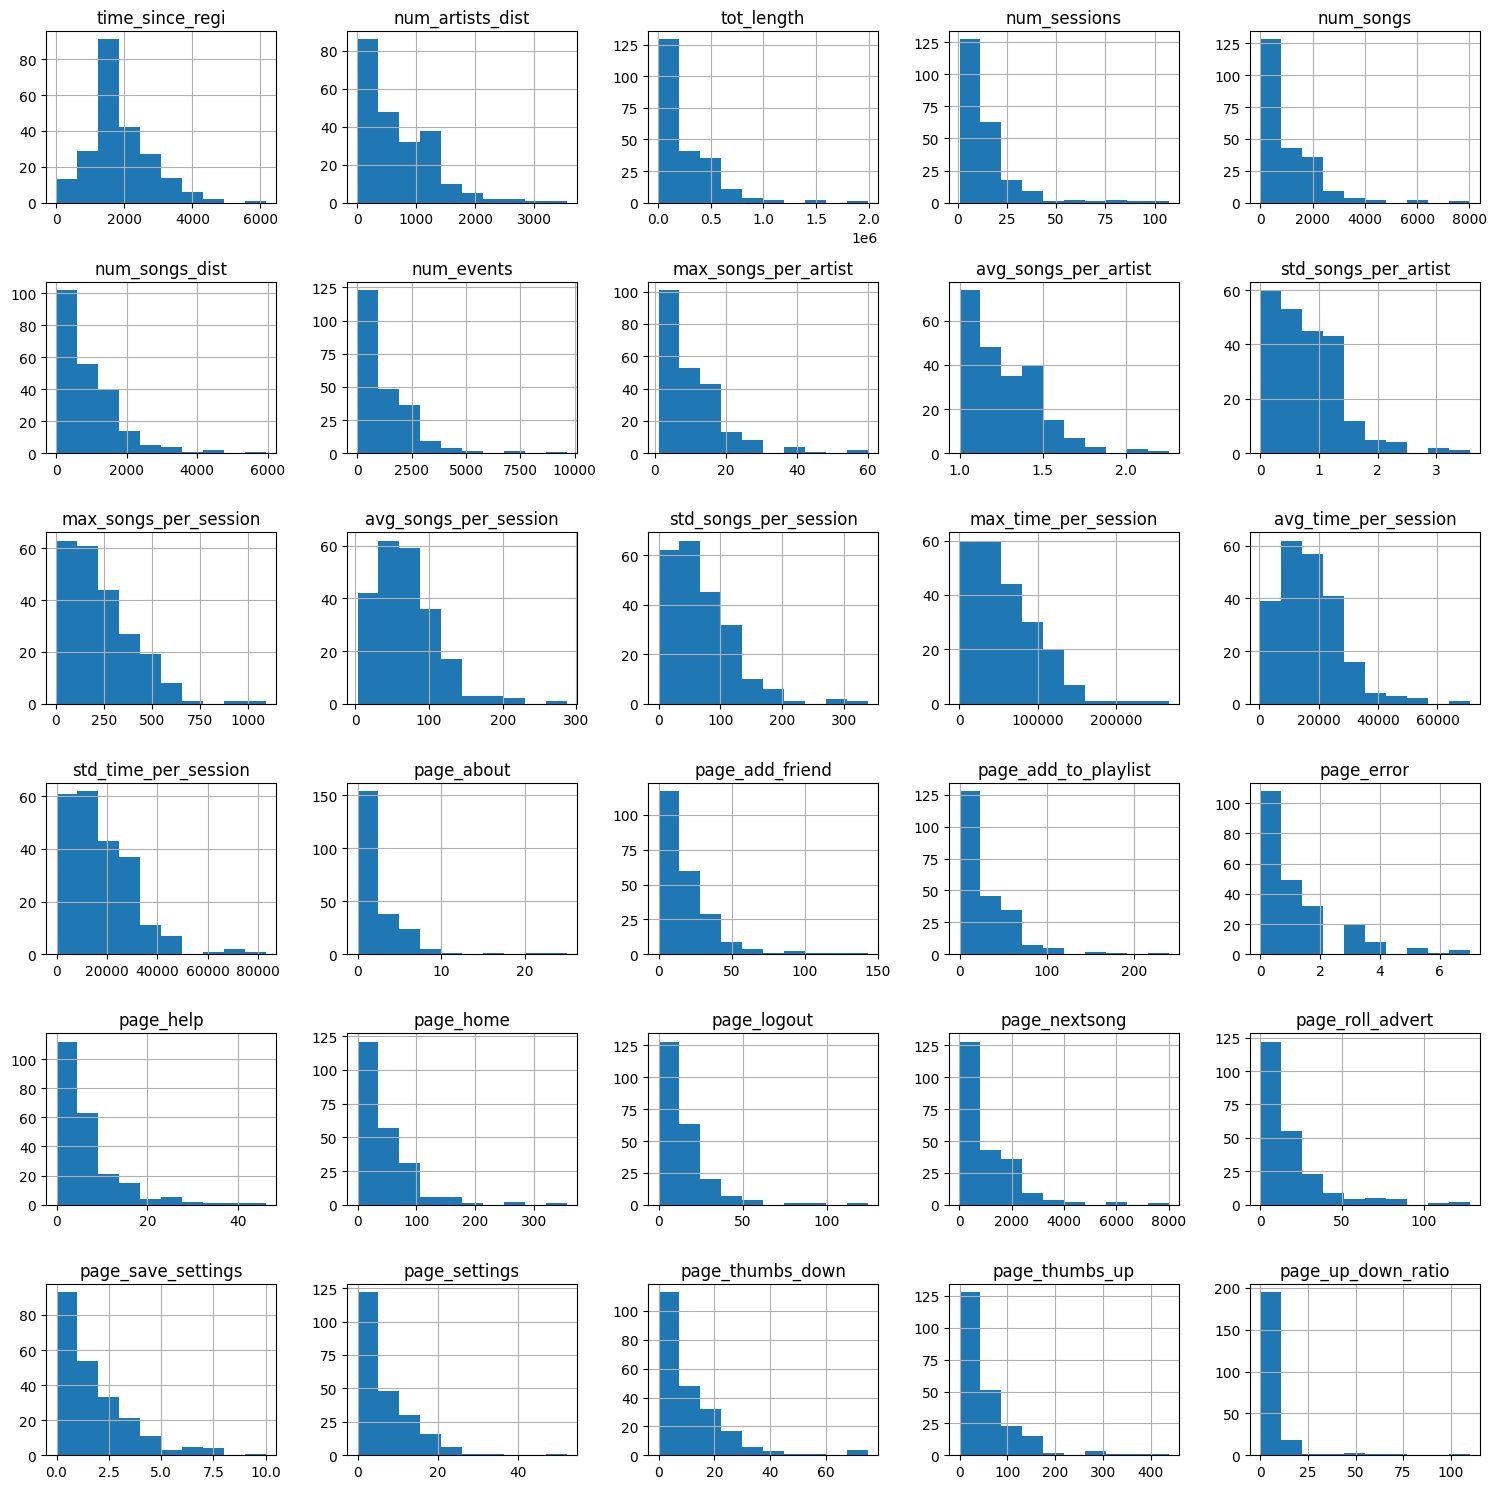

In [78]:
# Filter columns to exclude specific ones based on conditions
excluded_columns = ['churn', 'level', 'userId', 'gender', 'user_agent_', 'location_', '_submit_']
feature_columns = [col for col in dataset_as_pandas.columns if not any(exclusion in col for exclusion in excluded_columns)]

# Plot histograms of the selected features
print("Examining the distributions of selected features:")
axes = dataset_as_pandas[feature_columns].hist(figsize=(15, 15))

# Show the histograms
plt.tight_layout()
plt.show()

> Since the majority of the characteristics are skewed, I will alter them to make them more akin to normal distributions

### Adjust characteristics to approximate normal distributions

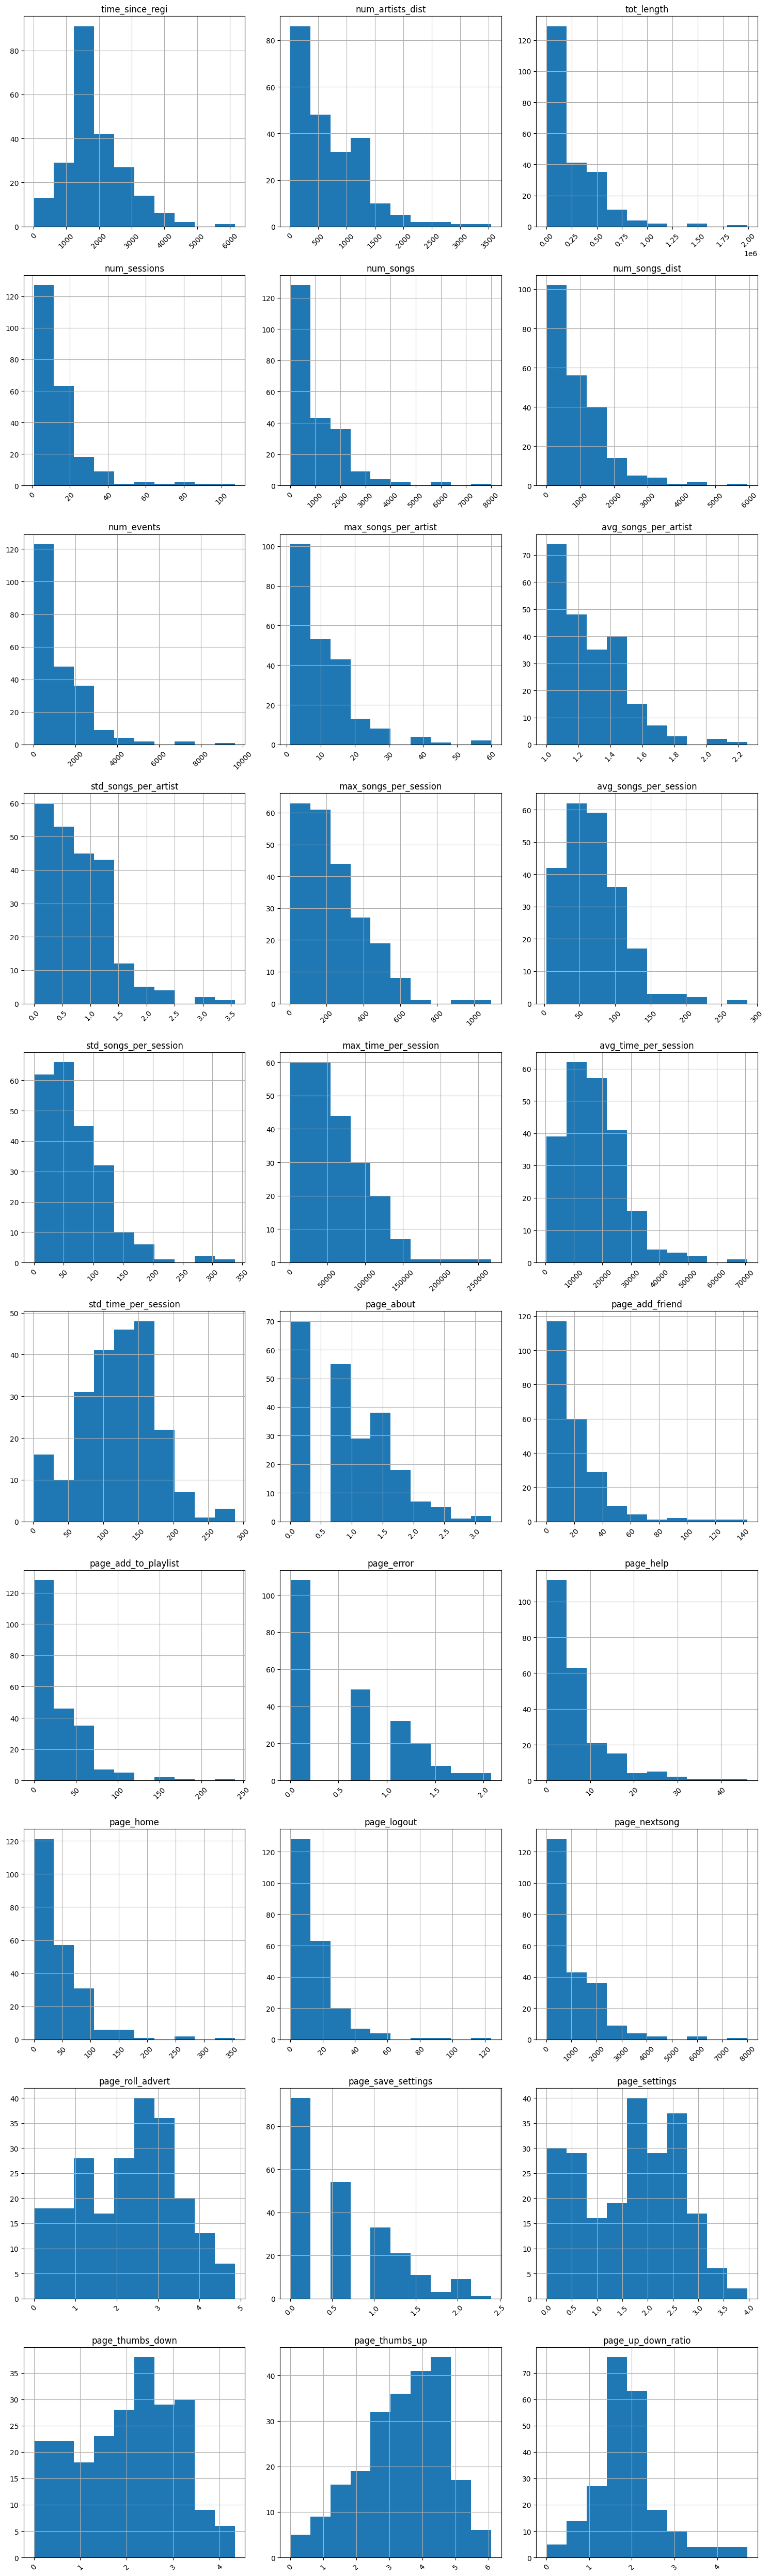

In [79]:
# Define the columns for transformation (as before)
sqrt_columns = ['std_time_per_session']
log_columns = [
    'page_about', 'page_error', 'page_roll_advert', 'page_save_settings',
    'page_thumbs_down', 'page_frac_about', 'page_frac_add_friend',
    'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help',
    'page_frac_home', 'page_frac_logout', 'page_frac_roll_advert',
    'page_frac_save_settings', 'page_frac_settings',
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade',
    'page_frac_thumbs_down', 'page_settings', 'page_thumbs_up',
    'page_up_down_ratio'
]

# Apply transformations on selected columns
for feature in feature_columns:
    if feature in sqrt_columns:
        dataset_as_pandas[feature] = dataset_as_pandas[feature].apply(lambda x: (x + 1) ** 0.5)
    elif feature in log_columns:
        dataset_as_pandas[feature] = dataset_as_pandas[feature].apply(lambda x: np.log(x + 1))

# Set up the number of rows and columns based on the number of features
n_features = len(feature_columns)
n_cols = 3  # Number of columns in the grid
n_rows = int(np.ceil(n_features / n_cols))  # Number of rows needed

# Create subplots with the calculated layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten the axes array to iterate over easily
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(feature_columns):
    dataset_as_pandas[col].hist(ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x labels if needed

# Hide any extra subplots if there are fewer columns than grid slots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Show the histograms
plt.tight_layout()
plt.show()

> In conclusion, the distributions now resemble normal

# Modeling

## Train-test split

In [80]:
# Rename churn column into label
dataset = combined_data.withColumn('label', combined_data['churn'].cast('float')).drop('churn') #important to have float type

# Feature columns to be converted into vector
feature_cols = dataset.drop('label').drop('userId').columns

# Train-test split
train, test = dataset.drop('userId').randomSplit([0.8, 0.2], seed=1999)

## Metric of Evaluation
> The dataset reveals an imbalance in the target labels, with churned users constituting a minority (23% churned vs. 77% non-churned). This imbalance presents challenges when selecting an appropriate evaluation metric.

> Using accuracy as the metric can be misleading in such scenarios. For instance, a naive model that predicts "non-churn" for every instance would achieve a high accuracy of 77% simply by reflecting the majority class, but it would completely fail to identify churned users. This limitation makes accuracy an unsuitable choice for evaluating performance in this case.

> $$F_1 = \frac{2*precision*recall}{precision + recall}$$

> Instead, the F1 score is a more effective metric. The F1 score is the harmonic mean of precision and recall, providing a balanced assessment of the model’s ability to identify churned users without overwhelming false positives. Precision ensures that predicted churns are truly churns, while recall minimizes the likelihood of missing actual churns. By focusing on this balance, the F1 score becomes a more meaningful measure for evaluating the model's performance in this imbalanced classification problem.

## Functions and Pipeline
> Create a pipeline for cross-validation

> Develop a model for machine learning

> Analyze the model's performance


Due to its ability to scale features to the range [-1, 1] by dividing through the max abs value without centering/shifting, we select MaxAbsScaler for scaling features because it does not destroy sparsity.

In [81]:
def create_cross_validator(model, parameter_grid):
    """
    Creates a cross-validation pipeline for model training and evaluation.

    Parameters:
        model: An untrained machine learning model.
        parameter_grid: A parameter grid for hyperparameter tuning.

    Returns:
        cross_validator: A configured cross-validator object.
    """
    # Step 1: Assemble feature columns into a single vector
    feature_assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")

    # Step 2: Scale the feature vector for better optimization
    feature_scaler = MaxAbsScaler(inputCol="assembled_features", outputCol="scaled_features")

    # Step 3: Define the pipeline with preprocessing and the model
    ml_pipeline = Pipeline(stages=[feature_assembler, feature_scaler, model])

    # Step 4: Set up cross-validation
    cross_validator = CrossValidator(
        estimator=ml_pipeline,
        estimatorParamMaps=parameter_grid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=3
    )

    return cross_validator

In [82]:
def train_ml_model(model, training_data, parameter_grid):
    """
    Train a machine learning model using cross-validation.

    Parameters:
        model: An untrained machine learning model.
        training_data (Spark DataFrame): The dataset to train the model on.
        parameter_grid: Hyperparameter grid for model tuning.

    Returns:
        trained_model: The trained model after cross-validation.
        elapsed_time (float): Time taken to train the model.
    """
    # Step 1: Configure cross-validation with preprocessing and tuning
    cross_validator = create_cross_validator(model, parameter_grid)

    # Step 2: Train the model and measure time taken
    start_time = time()
    trained_model = cross_validator.fit(training_data)
    elapsed_time = time() - start_time

    return trained_model, elapsed_time

In [83]:
def evaluate_model_performance(trained_model, dataset, use_probability=False):
    """
    Assess the performance of a machine learning model.

    Parameters:
        trained_model: The trained ML model to evaluate.
        dataset (Spark DataFrame): Dataset for evaluation (train/test).
        use_probability (bool): If True, evaluate based on probability column instead of predictions.

    Returns:
        evaluation_results (dict): Dictionary containing evaluation metrics.
    """
    # Step 1: Make predictions
    start_time = time()
    predictions = trained_model.transform(dataset)
    evaluator = MulticlassClassificationEvaluator(
        predictionCol="probability" if use_probability else "prediction",
        labelCol="label"
    )
    prediction_duration = time() - start_time

    # Step 2: Calculate metrics
    evaluation_results = {
        "precision": evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"}),
        "recall": evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}),
        "f1_score": evaluator.evaluate(predictions, {evaluator.metricName: "f1"}),
        "accuracy": evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}),
        "confusion_matrix": predictions.groupby("label").pivot("prediction").count(),
        "prediction_duration": prediction_duration,
    }

    return evaluation_results

In [84]:
def evaluate_train_test_performance(trained_model, train_set, test_set, training_duration):
    """
    Compare the model's performance on both training and testing datasets.

    Parameters:
        trained_model: The trained ML model to evaluate.
        train_set (Spark DataFrame): Training dataset.
        test_set (Spark DataFrame): Testing dataset.
        training_duration (float): Time taken to train the model.

    Returns:
        combined_metrics (dict): Consolidated evaluation metrics for training and testing datasets.
        evaluation_summary (Spark DataFrame): Summary table with key metrics.
    """
    # Step 1: Evaluate the model on training and testing data
    training_metrics = evaluate_model_performance(trained_model, train_set)
    testing_metrics = evaluate_model_performance(trained_model, test_set)

    # Step 2: Combine results into a single dictionary
    combined_metrics = {
        "training_time": training_duration,
        "f1_train": training_metrics["f1_score"],
        "accuracy_train": training_metrics["accuracy"],
        "f1_test": testing_metrics["f1_score"],
        "accuracy_test": testing_metrics["accuracy"],
        "total_prediction_time": training_metrics["prediction_duration"] + testing_metrics["prediction_duration"],
    }

    # Step 3: Create a Spark DataFrame summary
    metrics_summary = {
        key: round(value, 4) for key, value in combined_metrics.items() if key != "confusion_matrix"
    }
    evaluation_summary = spark.createDataFrame(
        pd.DataFrame([metrics_summary], columns=metrics_summary.keys())
    )

    return combined_metrics, evaluation_summary

In [85]:
def train_and_evaluate_model(ml_classifier, training_set, testing_set, parameter_grid):
    """
    Train and evaluate a machine learning model on both training and testing datasets.

    Parameters:
        ml_classifier: Untrained machine learning classifier.
        training_set: Dataset to train the model.
        testing_set: Dataset to test the model.
        parameter_grid: Grid of hyperparameters for optimization.

    Returns:
        evaluation_results (dict): Consolidated evaluation metrics for training and testing datasets.
        metrics_summary (Spark DataFrame): Summary of evaluation metrics.
        trained_model: Trained machine learning model.
    """
    # Step 1: Train the model and record training time
    trained_model, train_duration = train_ml_model(ml_classifier, training_set, parameter_grid)

    # Step 2: Evaluate the trained model on training and testing datasets
    train_metrics = evaluate_model_performance(trained_model, training_set)
    test_metrics = evaluate_model_performance(trained_model, testing_set)

    # Step 3: Aggregate evaluation metrics
    evaluation_results = {
        "training_time": train_duration,
        "f1_train": train_metrics["f1_score"],
        "accuracy_train": train_metrics["accuracy"],
        "f1_test": test_metrics["f1_score"],
        "accuracy_test": test_metrics["accuracy"],
        "total_prediction_time": train_metrics["prediction_duration"] + test_metrics["prediction_duration"],
    }

    # Step 4: Create a summary table of metrics
    metrics_to_display = {
        metric: round(value, 4)
        for metric, value in evaluation_results.items()
        if metric != "confusion_matrix"
    }
    metrics_summary = spark.createDataFrame(
        pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys())
    )

    return evaluation_results, metrics_summary, trained_model

## Preliminary assessment of the model
> Use the default hyperparameters to compare the performance of various models.

### Baseline model

Describe a label=0 naïve model that consistently predicts no-churn. To provide a baseline of model performance, I will compute the F1 score and accuracy score of this basic model. Better performance should be possible with the adjusted machine learning model

In [86]:
# Step 1: Generate baseline predictions (all predictions set to 0.0)
baseline_predictions = dataset.withColumn("prediction", lit(0.0)).select("label", "prediction")

# Step 2: Initialize the evaluator
metric_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Step 3: Compute evaluation metrics
baseline_metrics = {
    "Precision (Weighted)": metric_evaluator.evaluate(baseline_predictions, {metric_evaluator.metricName: "weightedPrecision"}),
    "Recall (Weighted)": metric_evaluator.evaluate(baseline_predictions, {metric_evaluator.metricName: "weightedRecall"}),
    "F1 Score": metric_evaluator.evaluate(baseline_predictions, {metric_evaluator.metricName: "f1"}),
    "Accuracy": metric_evaluator.evaluate(baseline_predictions, {metric_evaluator.metricName: "accuracy"})
}

# Step 4: Calculate the confusion matrix
confusion_matrix = baseline_predictions.groupBy("label").pivot("prediction").count()

# Step 5: Display the metrics
print("Baseline Model Performance:")
metrics_df = spark.createDataFrame(
    pd.DataFrame([{metric: round(value, 4) for metric, value in baseline_metrics.items()}])
)
metrics_df.show()

# Optionally display the confusion matrix
confusion_matrix.show()

Baseline Model Performance:
+--------------------+-----------------+--------+--------+
|Precision (Weighted)|Recall (Weighted)|F1 Score|Accuracy|
+--------------------+-----------------+--------+--------+
|              0.5912|           0.7689|  0.6684|  0.7689|
+--------------------+-----------------+--------+--------+

+-----+---+
|label|0.0|
+-----+---+
|  0.0|173|
|  1.0| 52|
+-----+---+



### Logistic Regression

In [87]:
# Step 1: Initialize and configure the classifier
logistic_reg = LogisticRegression(featuresCol="scaled_features", labelCol="label")  # Updated column name
parameter_grid = ParamGridBuilder().build()

# Step 2: Train the model and evaluate its performance
baseline_metrics, summary, trained_model = train_and_evaluate_model(logistic_reg, train, test, parameter_grid)

# Step 3: Extract and save the best-performing model
optimal_model = trained_model.bestModel
logistic_classifier_model = optimal_model.stages[2]
logistic_classifier_model.save("logistic_regression_model")
# Alternatively, overwrite the model if needed
# logistic_classifier_model.write().overwrite().save("logistic_regression_model")

# Step 4: Display evaluation metrics
print("Performance Metrics for Logistic Regression:")
summary.show()

Performance Metrics for Logistic Regression:
+-------------+--------+--------------+-------+-------------+---------------------+
|training_time|f1_train|accuracy_train|f1_test|accuracy_test|total_prediction_time|
+-------------+--------+--------------+-------+-------------+---------------------+
|     648.1715|  0.8685|        0.8729| 0.6706|       0.6818|               1.3453|
+-------------+--------+--------------+-------+-------------+---------------------+



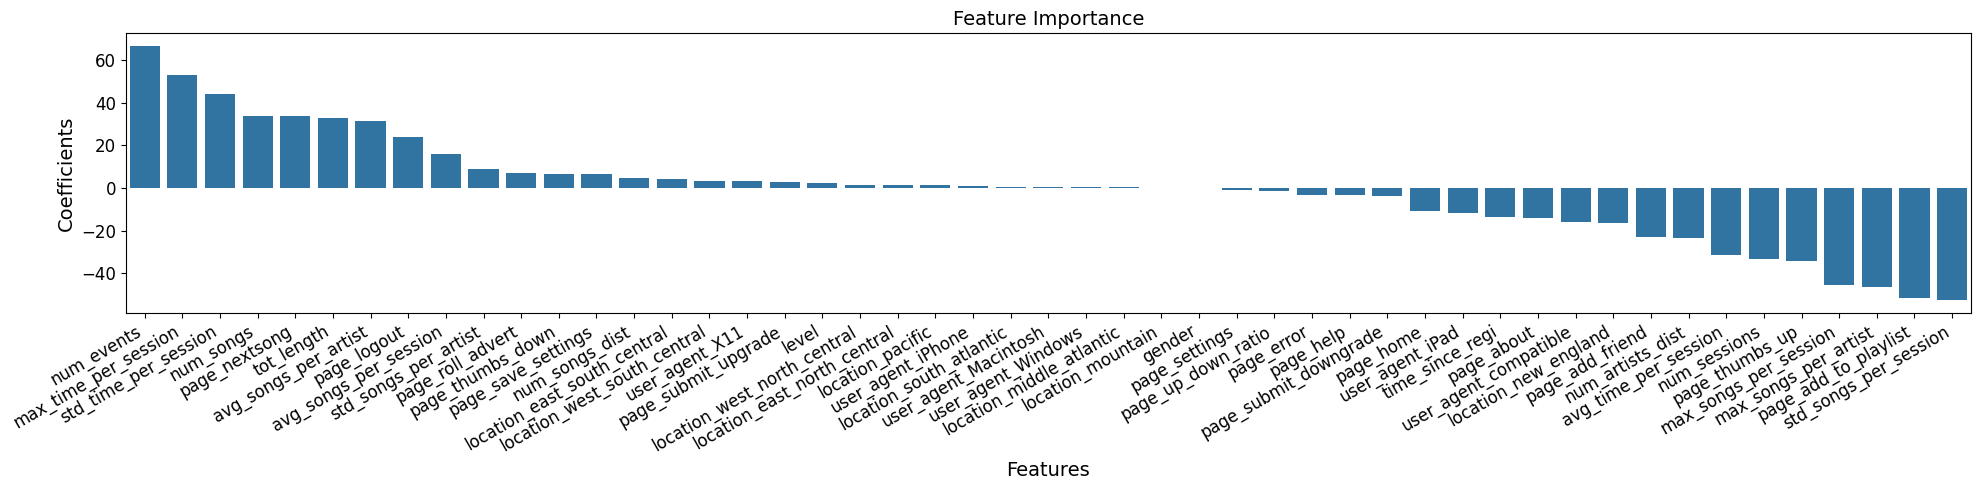

In [88]:
# Load the pre-trained logistic regression model
loaded_logistic_model = LogisticRegressionModel.load("logistic_regression_model")

# Extract feature coefficients
coefficients = loaded_logistic_model.coefficients.toArray().tolist()
coefficients_data = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Visualize feature importance
plt.figure(figsize=(20, 5))
sns.barplot(data=coefficients_data, x='Feature', y='Coefficient')
plt.title('Feature Importance', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Coefficients', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [89]:
print(feature_cols)

['level', 'time_since_regi', 'gender', 'num_artists_dist', 'tot_length', 'num_sessions', 'num_songs', 'num_songs_dist', 'num_events', 'max_songs_per_artist', 'avg_songs_per_artist', 'std_songs_per_artist', 'max_songs_per_session', 'avg_songs_per_session', 'std_songs_per_session', 'max_time_per_session', 'avg_time_per_session', 'std_time_per_session', 'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone', 'page_about', 'page_add_friend', 'page_add_to_playlist', 'page_error', 'page_help', 'page_home', 'page_logout', 'page_nextsong', 'page_roll_advert', 'page_save_settings', 'page_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_up_down_ratio', 'location_east_north_central', 'location_east_south_central', 'location_middle_atlantic', 'location_mountain', 'location_new_england', 'location_pacific', 'location_south_atlantic', 'location_west_north_central', 'location

### Random Forest

In [90]:
# Step 1: Initialize and configure the classifier
rnd_Forest = RandomForestClassifier(featuresCol="scaled_features", labelCol="label")  # Updated column name
parameter_grid = ParamGridBuilder().build()

# Step 2: Train the model and evaluate its performance
baseline_metrics, summary, trained_model = train_and_evaluate_model(rnd_Forest, train, test, parameter_grid)

# Step 3: Extract and save the best-performing model
optimal_model = trained_model.bestModel
random_forest_model = optimal_model.stages[2]
random_forest_model.save("random_forest")
# Alternatively, overwrite the model if needed
# random_forest_model.write().overwrite().save("random_forest")

# Step 4: Display evaluation metrics
print("Performance Metrics for Random Forest:")
summary.show()

Performance Metrics for Random Forest:
+-------------+--------+--------------+-------+-------------+---------------------+
|training_time|f1_train|accuracy_train|f1_test|accuracy_test|total_prediction_time|
+-------------+--------+--------------+-------+-------------+---------------------+
|     696.1144|  0.9165|        0.9227| 0.6429|         0.75|               0.9643|
+-------------+--------+--------------+-------+-------------+---------------------+



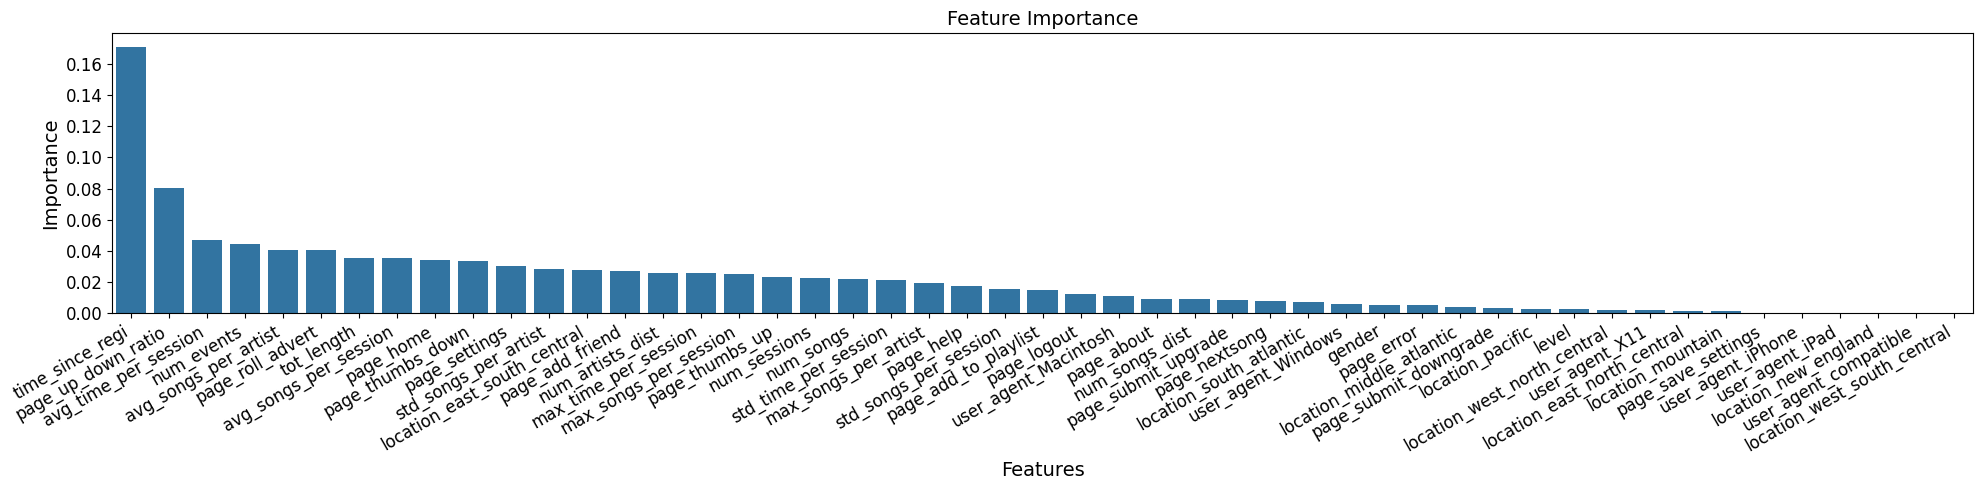

In [91]:
# Load the pre-trained Random Forest model
loaded_rnd_Forest = RandomForestClassificationModel.load("random_forest")

# Extract feature importances (relative importance of each feature)
feature_importances = loaded_rnd_Forest.featureImportances

# Convert to DataFrame for visualization
coefficients_data = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances.toArray()
}).sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(20, 5))
sns.barplot(data=coefficients_data, x='Feature', y='Importance')
plt.title('Feature Importance', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [92]:
print(feature_cols)

['level', 'time_since_regi', 'gender', 'num_artists_dist', 'tot_length', 'num_sessions', 'num_songs', 'num_songs_dist', 'num_events', 'max_songs_per_artist', 'avg_songs_per_artist', 'std_songs_per_artist', 'max_songs_per_session', 'avg_songs_per_session', 'std_songs_per_session', 'max_time_per_session', 'avg_time_per_session', 'std_time_per_session', 'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone', 'page_about', 'page_add_friend', 'page_add_to_playlist', 'page_error', 'page_help', 'page_home', 'page_logout', 'page_nextsong', 'page_roll_advert', 'page_save_settings', 'page_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_up_down_ratio', 'location_east_north_central', 'location_east_south_central', 'location_middle_atlantic', 'location_mountain', 'location_new_england', 'location_pacific', 'location_south_atlantic', 'location_west_north_central', 'location

### Gradient-Boosted Tree

In [93]:
# Step 1: Initialize and configure the classifier
gra_bst = GBTClassifier(featuresCol="scaled_features", labelCol="label")  # Updated column name
parameter_grid = ParamGridBuilder().build()

# Step 2: Train the model and evaluate its performance
baseline_metrics, summary, trained_model = train_and_evaluate_model(gra_bst, train, test, parameter_grid)

# Step 3: Extract and save the best-performing model
optimal_model = trained_model.bestModel
GBTClassificationModel = optimal_model.stages[2]
GBTClassificationModel.save("GBTClassificationModel")
# Alternatively, overwrite the model if needed
# GBTClassificationModel.write().overwrite().save("GBTClassificationModel")

# Step 4: Display evaluation metrics
print("Performance Metrics for Gradient-Boosted Tree:")
summary.show()

Performance Metrics for Gradient-Boosted Tree:
+-------------+--------+--------------+-------+-------------+---------------------+
|training_time|f1_train|accuracy_train|f1_test|accuracy_test|total_prediction_time|
+-------------+--------+--------------+-------+-------------+---------------------+
|     564.1485|     1.0|           1.0| 0.6714|       0.6591|               0.7612|
+-------------+--------+--------------+-------+-------------+---------------------+



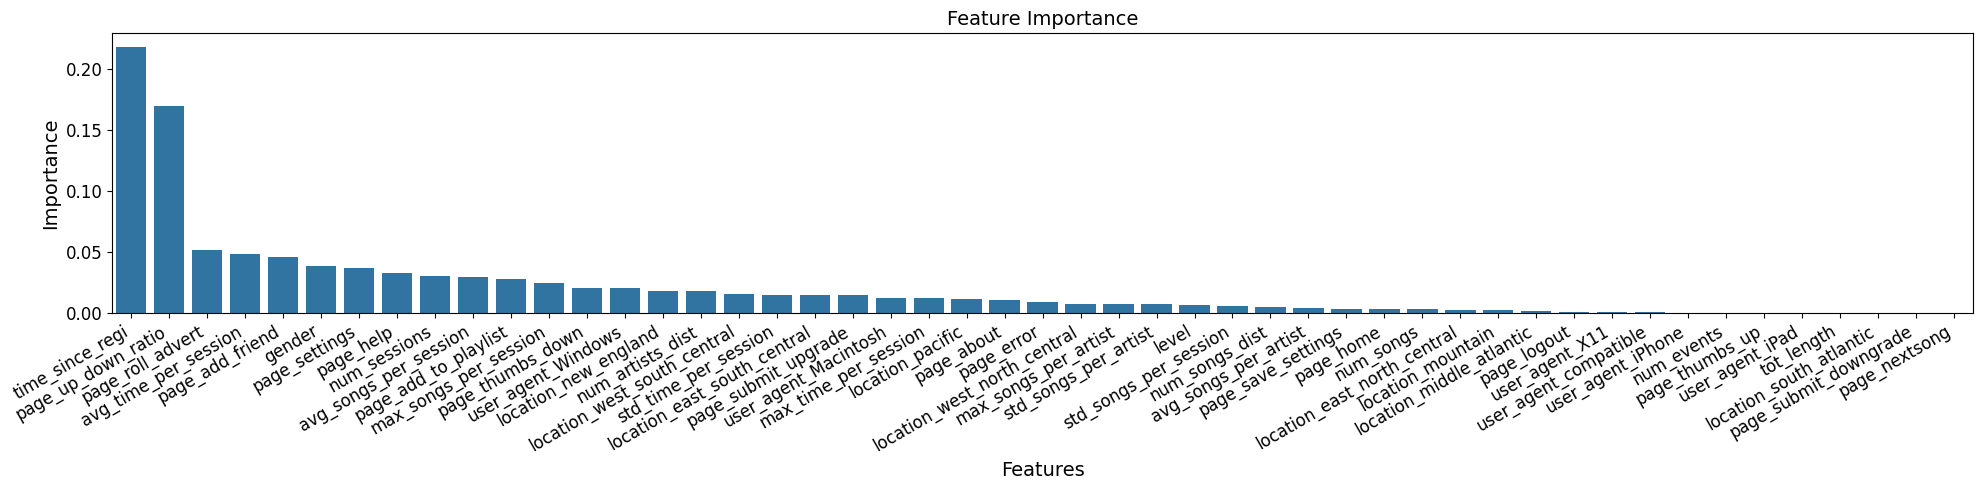

In [94]:
# Load the pre-trained Gradient-Boosted Tree
loaded_Gra_bts = GBTClassificationModel.load("GBTClassificationModel")

# Extract feature importances (relative importance of each feature)
feature_importances = loaded_Gra_bts.featureImportances

# Convert to DataFrame for visualization
coefficients_data = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances.toArray()
}).sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(20, 5))
sns.barplot(data=coefficients_data, x='Feature', y='Importance')
plt.title('Feature Importance', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [95]:
print(feature_cols)

['level', 'time_since_regi', 'gender', 'num_artists_dist', 'tot_length', 'num_sessions', 'num_songs', 'num_songs_dist', 'num_events', 'max_songs_per_artist', 'avg_songs_per_artist', 'std_songs_per_artist', 'max_songs_per_session', 'avg_songs_per_session', 'std_songs_per_session', 'max_time_per_session', 'avg_time_per_session', 'std_time_per_session', 'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone', 'page_about', 'page_add_friend', 'page_add_to_playlist', 'page_error', 'page_help', 'page_home', 'page_logout', 'page_nextsong', 'page_roll_advert', 'page_save_settings', 'page_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_up_down_ratio', 'location_east_north_central', 'location_east_south_central', 'location_middle_atlantic', 'location_mountain', 'location_new_england', 'location_pacific', 'location_south_atlantic', 'location_west_north_central', 'location

| **Model**                | **Train Time (s)** | **F1 Train** | **Acc Train** | **F1 Test** | **Acc Test** | **Prediction Time (s)** |
|--------------------------|-------------------|-------------|-------------|------------|------------|-------------------------|
| **Naive Model**          | -                 | -           | -           | **0.6684** | **0.7689** | -                      |
| **Logistic Regression**  | 648.1715          | 0.8685      | 0.8729      | 0.6706     | 0.6818     | 1.3453                 |
| **Random Forest**        | 696.1144          | 0.9165      | 0.9227      | **0.6429** | **0.7500** | 0.9643                 |
| **Gradient-Boosted Tree**| 564.1485          | **1.0**     | **1.0**     | 0.6714     | 0.6591     | **0.7612**             |


**Key Insights:**
- Naive Model: Based on the naive model for F1 = 0.6684 and Accuracy = 0.7689
- Logistic Regression:
  - Fast prediction time (1.3453s) but moderate test performance (F1 = 0.6706, Accuracy = 0.6818)
  - Shows slight overfitting, as training metrics are higher than test metrics
- Random Forest:
  - Provides the best test accuracy (75.00%) and decent test F1 score (0.6429)
  - Balances predictive power and generalization well
  - Moderate training time (696.1144s) and fast prediction time (0.9643s)
- Gradient-Boosted Tree:
  - Achieves perfect training metrics (F1 = 1.0, Accuracy = 1.0), indicating significant overfitting
  - Lowest test accuracy (65.91%) despite having the fastest training and prediction times
  - Requires tuning to mitigate overfitting

**Conclusion:**

> The Naive model that we use sets up a sensible benchmark to work with. Across the test accuracy and generalization, Random Forest is the best model that surpasses the naive model and other classifiers in the dataset. It is demonstrated that Gradient-Boosted Tree has the highest value of the V-score while the H-score reveals the overfitting of data which means that with selected hyperparameters the model can be optimized